In [1]:
# Basic
import numpy as np
from scipy import stats
import pandas as pd
from patsy import bs, dmatrix
import matplotlib.pyplot as plt
# Exploratory Analysis of Bayesian Models
import arviz as az
# Probabilistic programming languages
import bambi as bmb
import pymc as pm
import tensorflow_probability as tfp
tfd = tfp.distributions
az.style.use("arviz-grayscale")
plt.rcParams['figure.dpi'] = 300
np.random.seed(5201)
viridish = [(0.2823529411764706, 0.11372549019607843, 0.43529411764705883, 1.0),
            (0.1450980392156863, 0.6705882352941176, 0.5098039215686274, 1.0),
            (0.6901960784313725, 0.8666666666666667, 0.1843137254901961, 1.0)]

# WARNING
# The book is based on old libraries which give deprecation warnings
import warnings
## Quick fix for package version errors
warnings.filterwarnings("ignore")

In [2]:
penguins = pd.read_csv("../book/data/penguins.csv")

# Subset to the columns needed
missing_data = penguins.isnull()[["bill_length_mm", "flipper_length_mm", "sex", "body_mass_g"]].any(axis=1)

# Drop rows with any missing data
penguins = penguins.loc[~missing_data]

In [3]:
summary_stats = (penguins.loc[:, ["species", "body_mass_g"]]
                             .groupby("species")
                             .agg(["mean", "std", "count"]))
summary_stats

body_mass_g                  
                  mean         std count
species                                 
Adelie     3706.164384  458.620135   146
Chinstrap  3733.088235  384.335081    68
Gentoo     5092.436975  501.476154   119

In [4]:
adelie_mask = (penguins["species"] == "Adelie")
adelie_mass_obs = penguins.loc[adelie_mask, "body_mass_g"].values

with pm.Model() as model_adelie_penguin_mass:
    σ = pm.HalfStudentT("σ", 100, 2000)
    μ = pm.Normal("μ", 4000, 3000)
    mass = pm.Normal("mass", mu=μ, sigma=σ, observed=adelie_mass_obs)

    idata_adelie_mass = pm.sample(chains=4)
    idata_adelie_mass.extend(pm.sample_prior_predictive(samples=5000))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [mass, μ, σ]


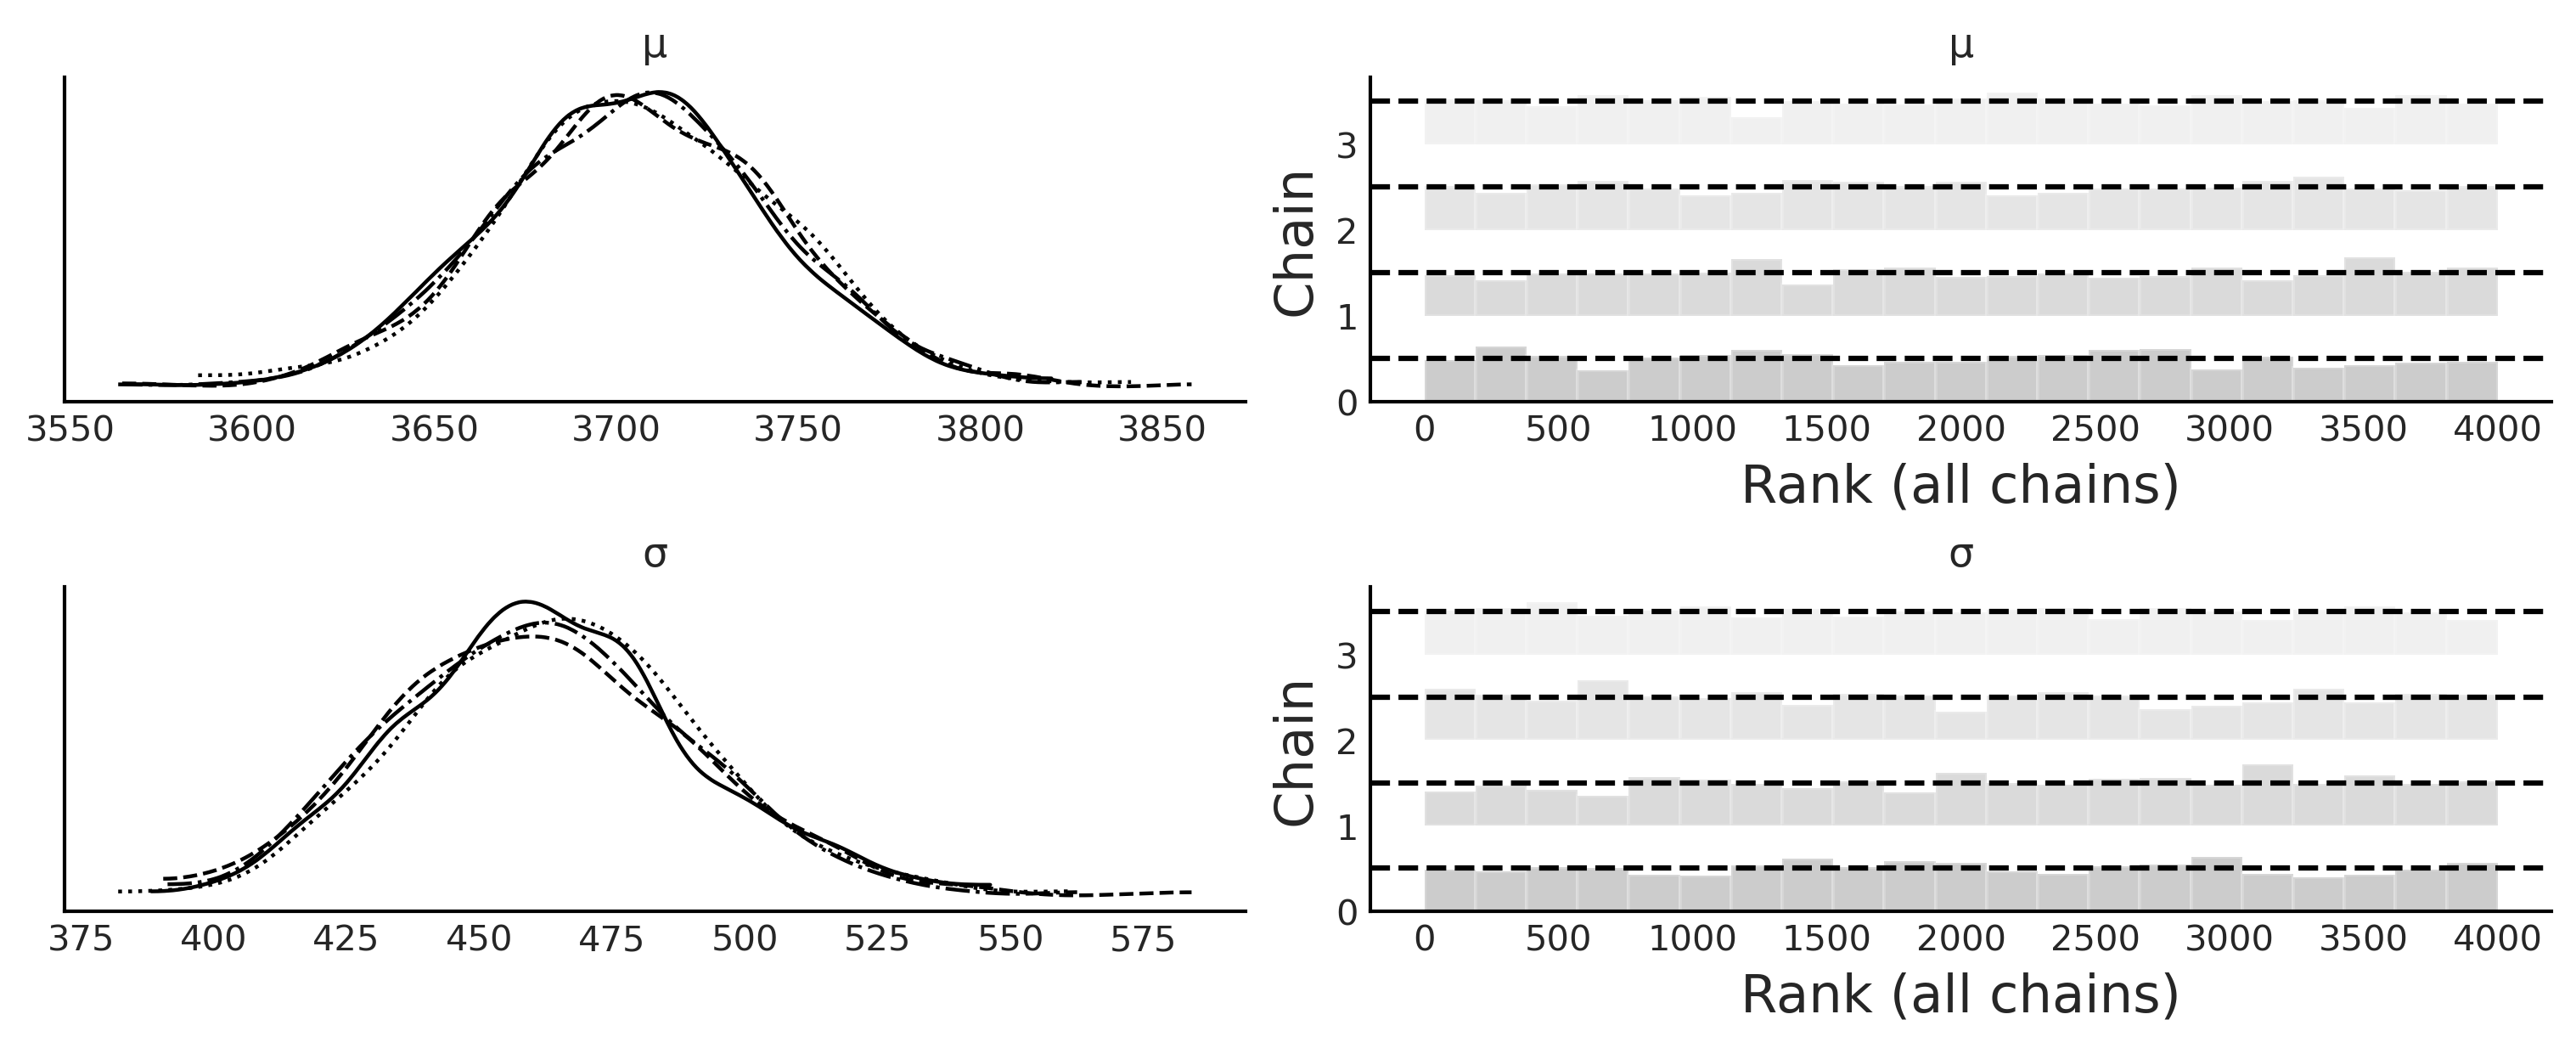

In [5]:
axes = az.plot_trace(idata_adelie_mass, divergences="bottom", kind="rank_bars", figsize=(10, 4))

plt.savefig("img/chap03/single_species_KDE_rankplot.png")

In [6]:
az.summary(idata_adelie_mass)

mean      sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
μ  3705.563  38.096  3632.615  3775.416      0.594    0.420    4126.0   
σ   462.892  27.490   410.493   512.241      0.439    0.311    3964.0   

   ess_tail  r_hat  
μ    2869.0    1.0  
σ    3021.0    1.0

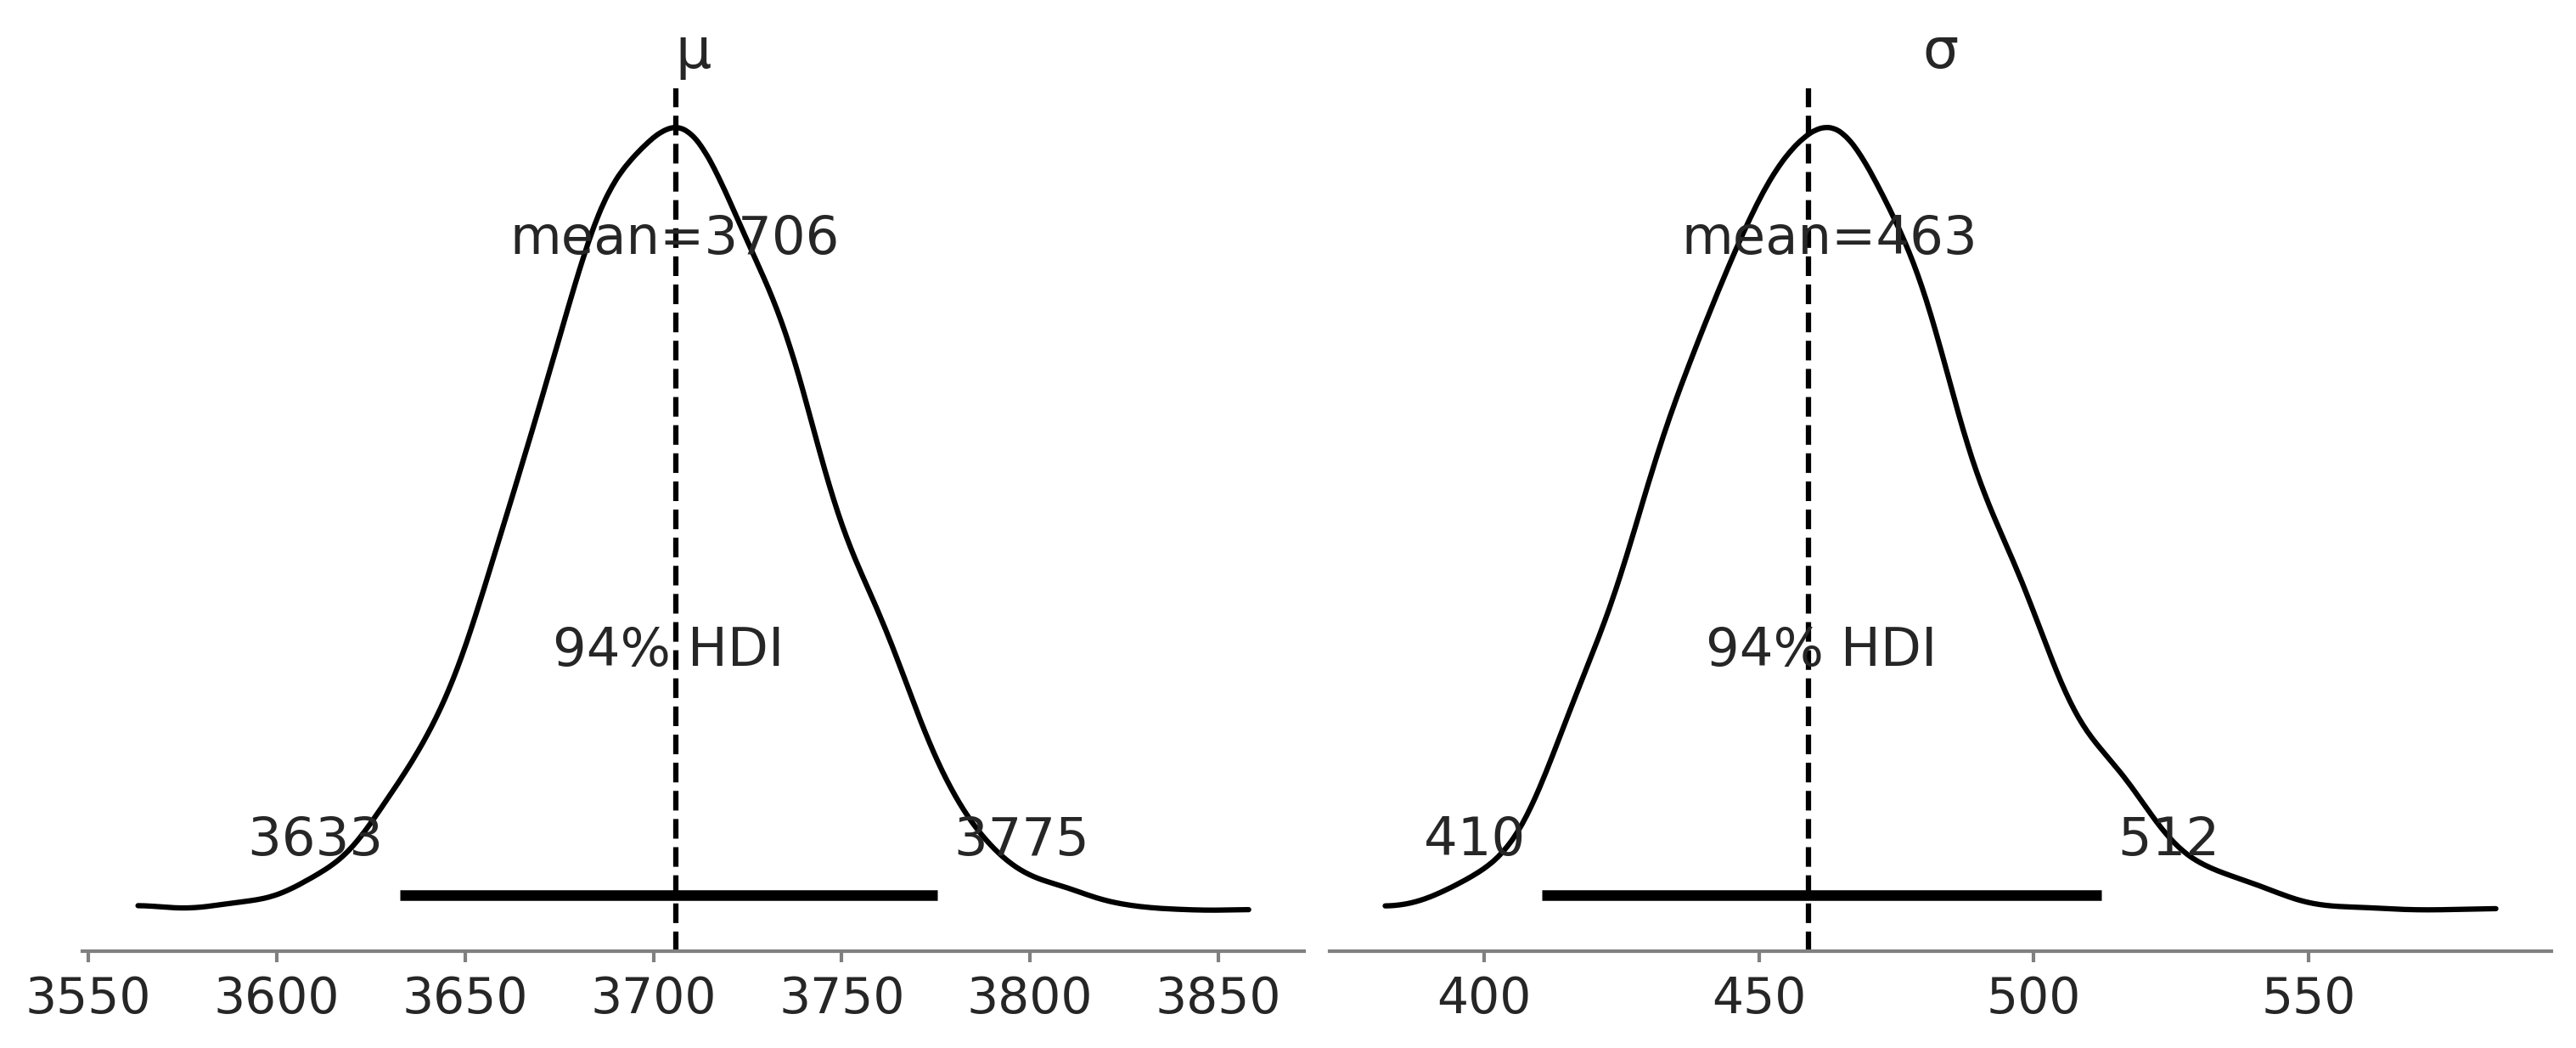

In [7]:
axes = az.plot_posterior(idata_adelie_mass, hdi_prob=.94, figsize=(10, 4));

# Copied from code output 3.2
axes[0].axvline(3706, linestyle="--")
axes[1].axvline(459, linestyle="--")
plt.savefig("img/chap03/single_species_mass_posteriorplot.png")

In [8]:
# All Species
all_species = pd.Categorical(penguins["species"])

with pm.Model() as model_penguin_mass_all_species:
    # Note the addition of the shape parameter
    σ = pm.HalfStudentT("σ", 100, 2000, shape=3)
    μ = pm.Normal("μ", 4000, 3000, shape=3)
    mass = pm.Normal("mass", 
                     mu=μ[all_species.codes], 
                     sigma=σ[all_species.codes],
                     observed=penguins["body_mass_g"]
                    )

    idata_penguin_mass_all_species = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


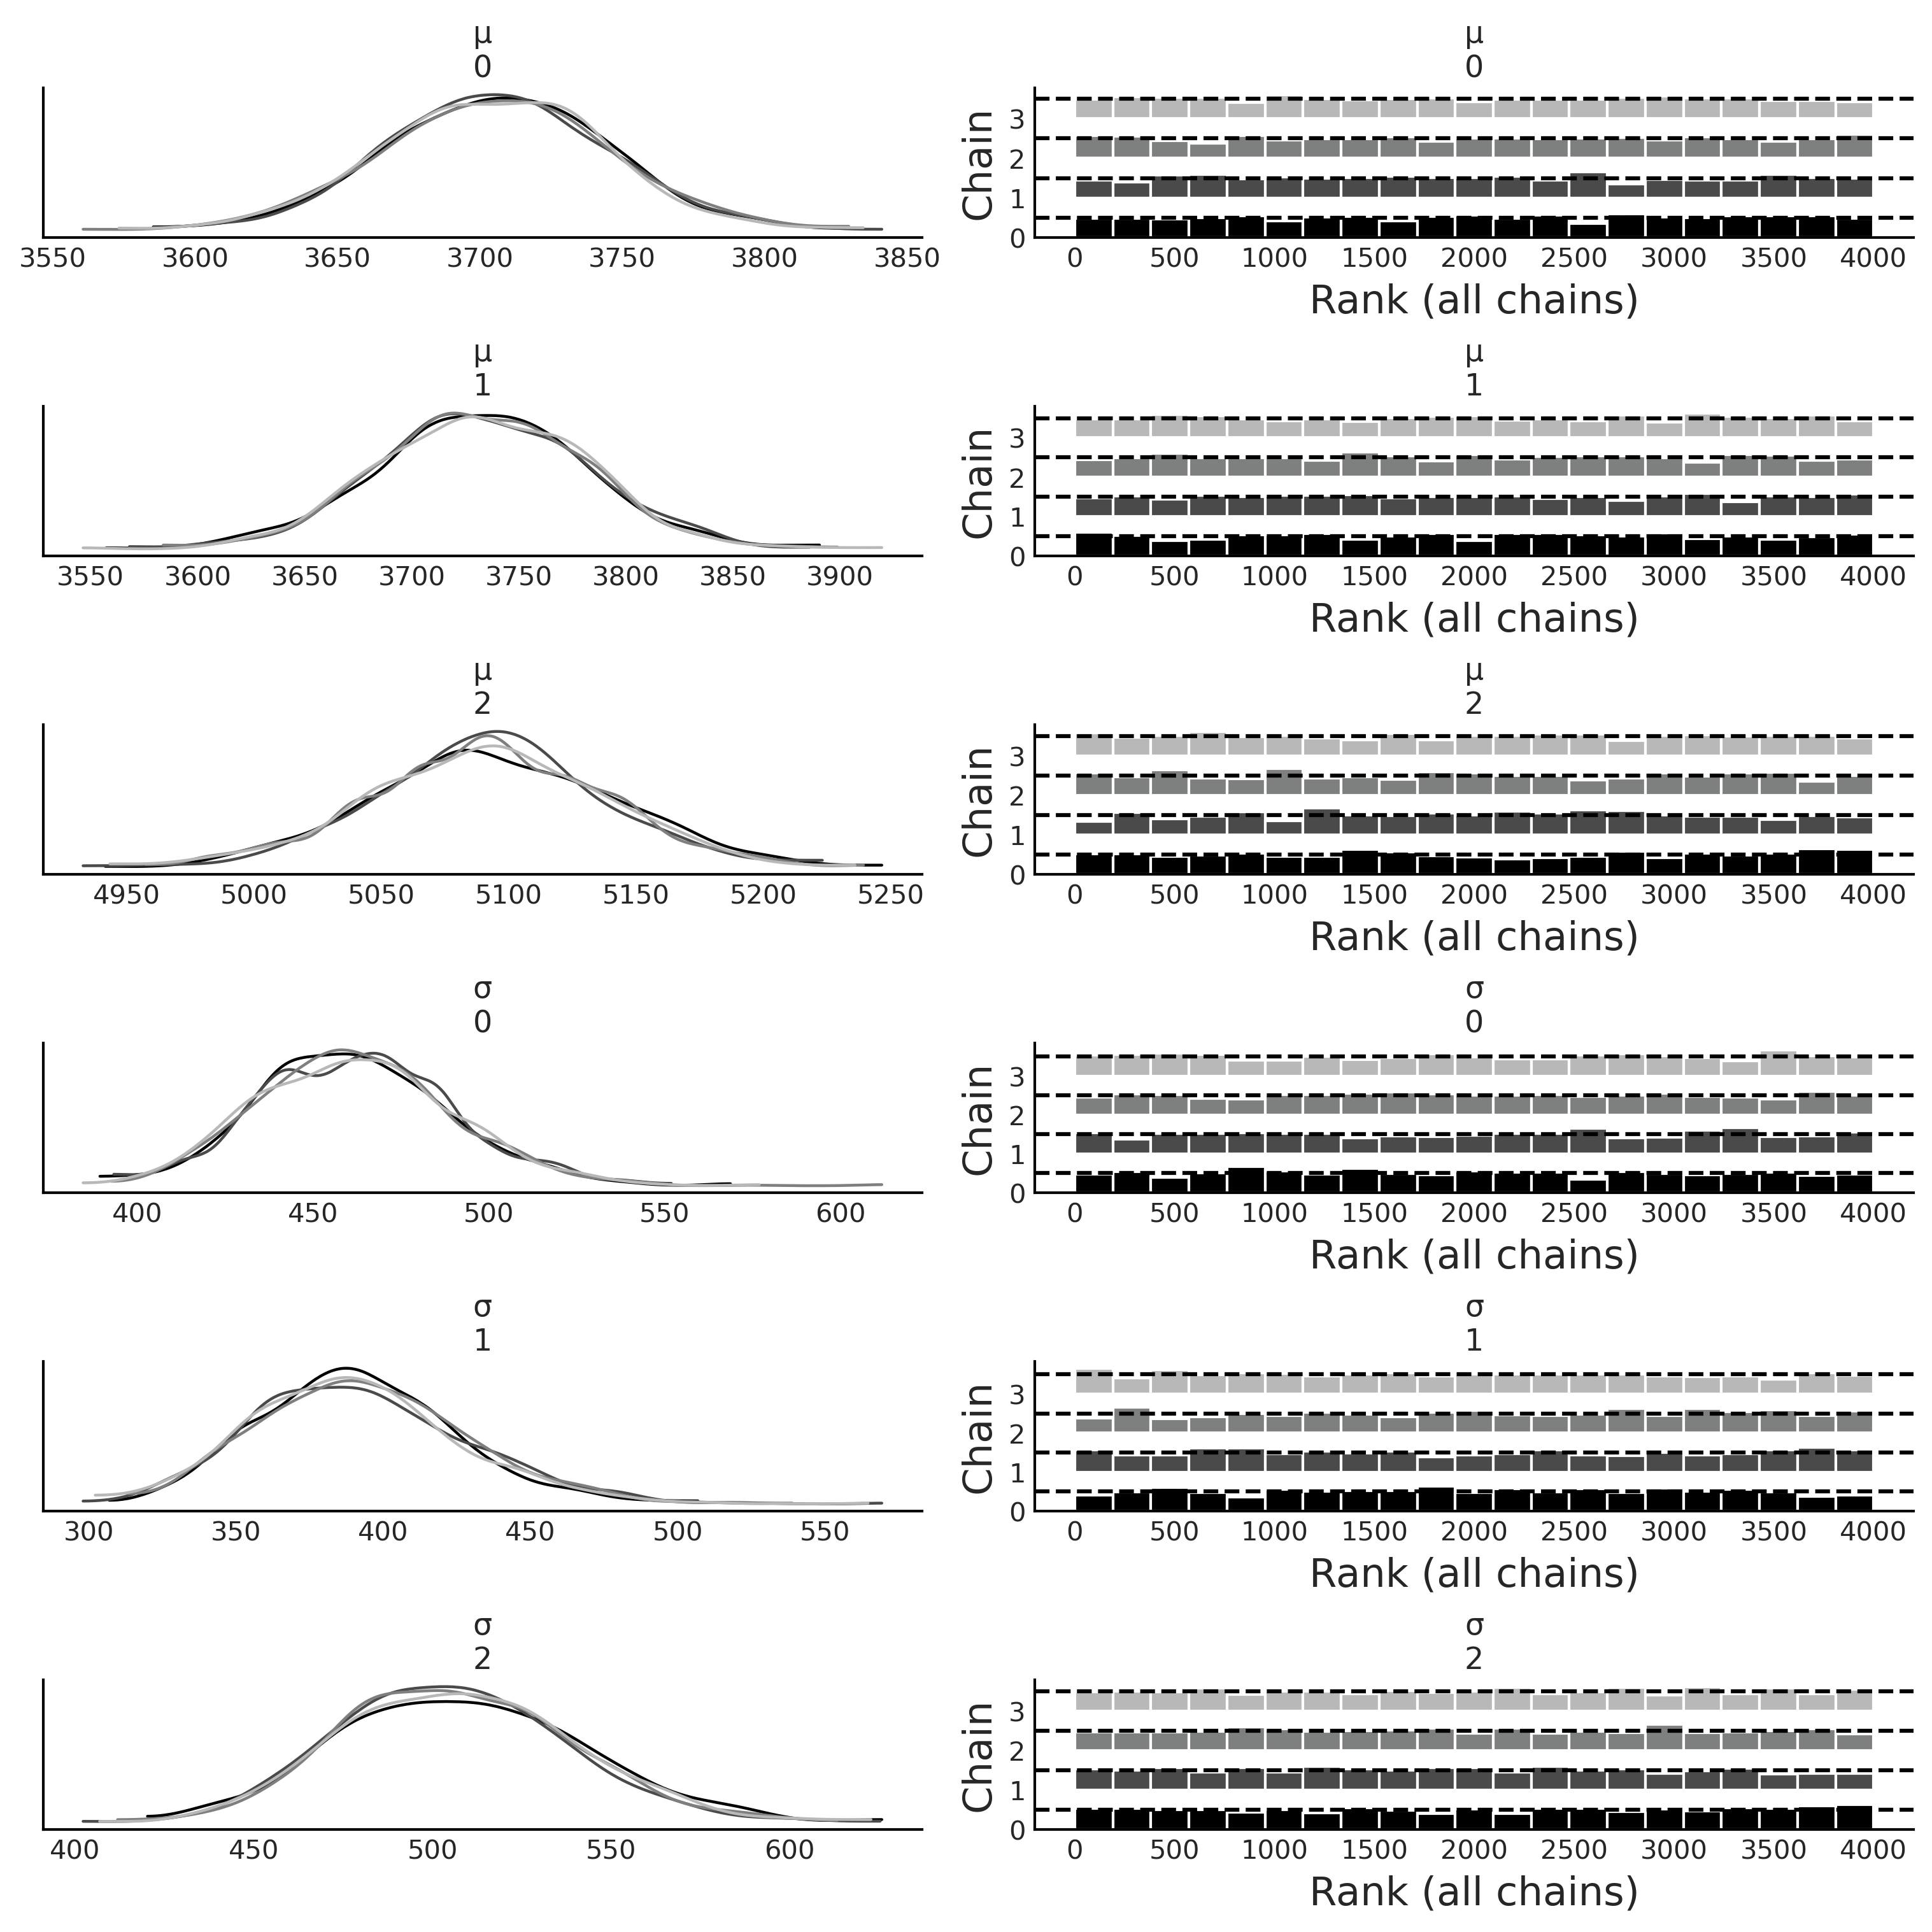

In [9]:
axes = az.plot_trace(idata_penguin_mass_all_species, compact=False, divergences="bottom", kind="rank_bars", figsize=(10, 10))
plt.savefig("img/chap03/all_species_KDE_rankplot.png")

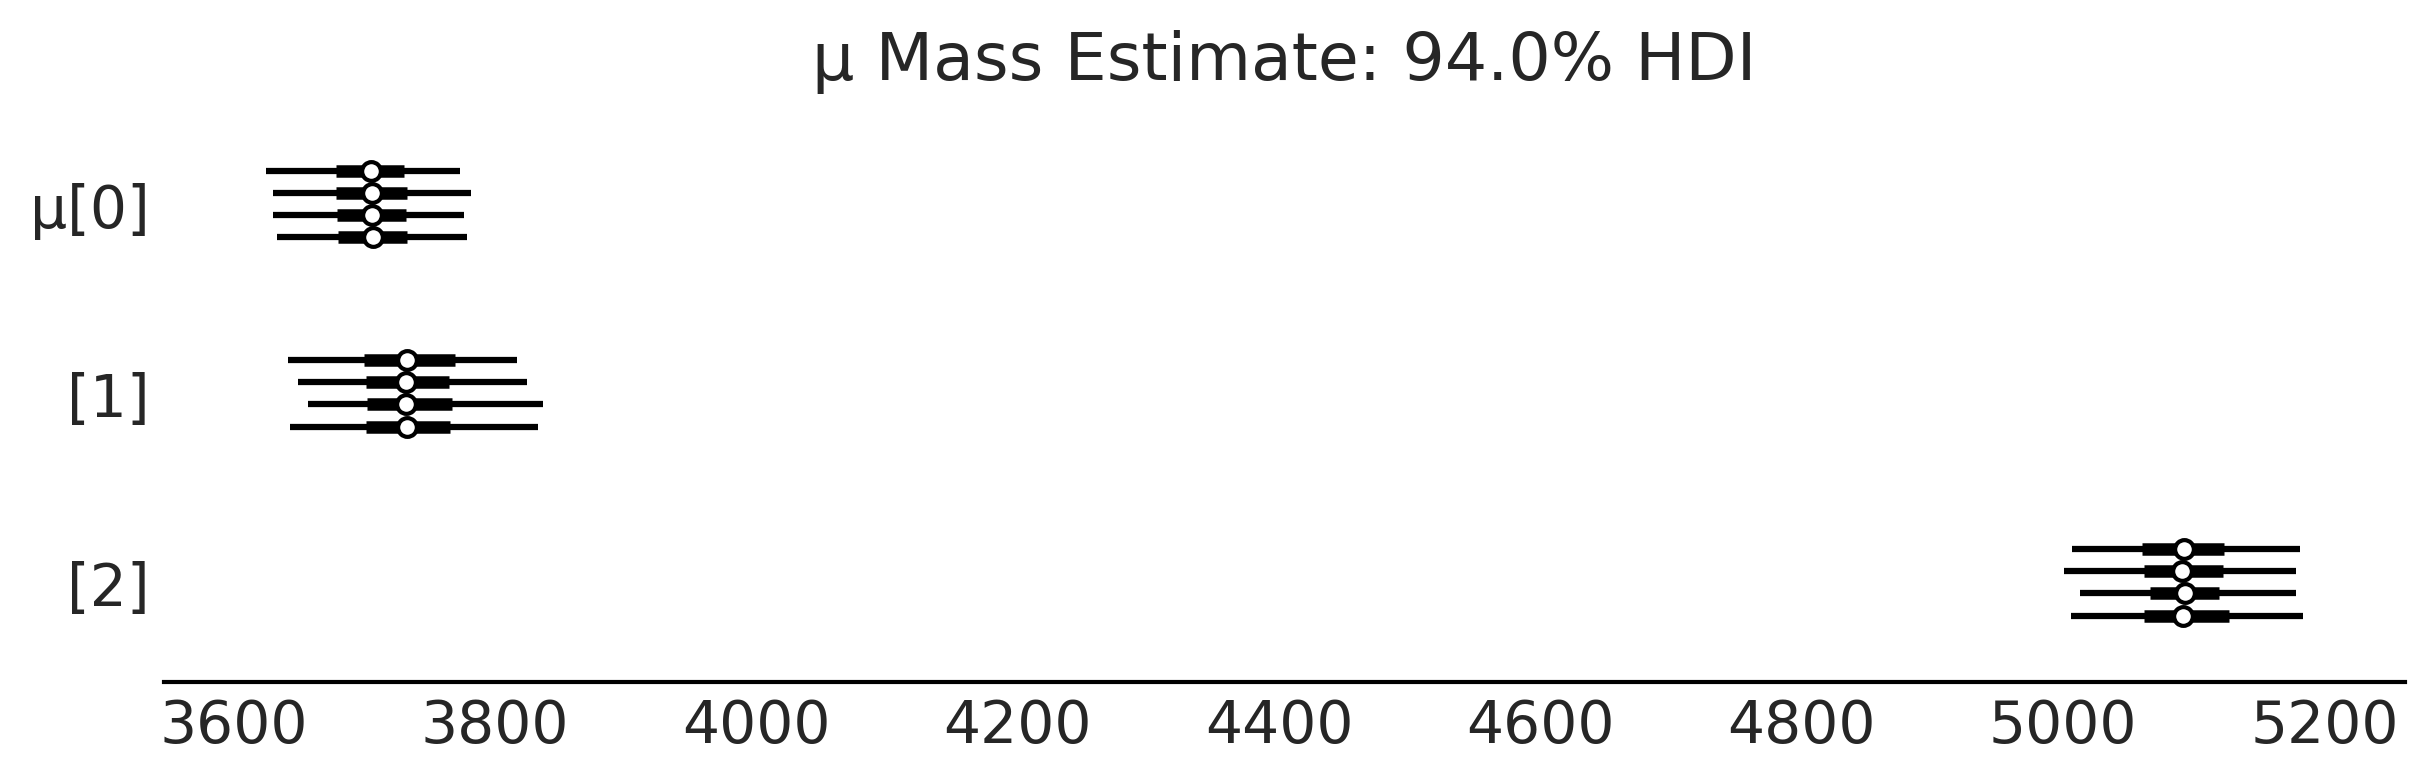

In [10]:
axes = az.plot_forest(idata_penguin_mass_all_species, var_names=["μ"], figsize=(8, 2.5))
axes[0].set_title("μ Mass Estimate: 94.0% HDI")

plt.savefig("img/chap03/independent_model_forestplotmeans.png")

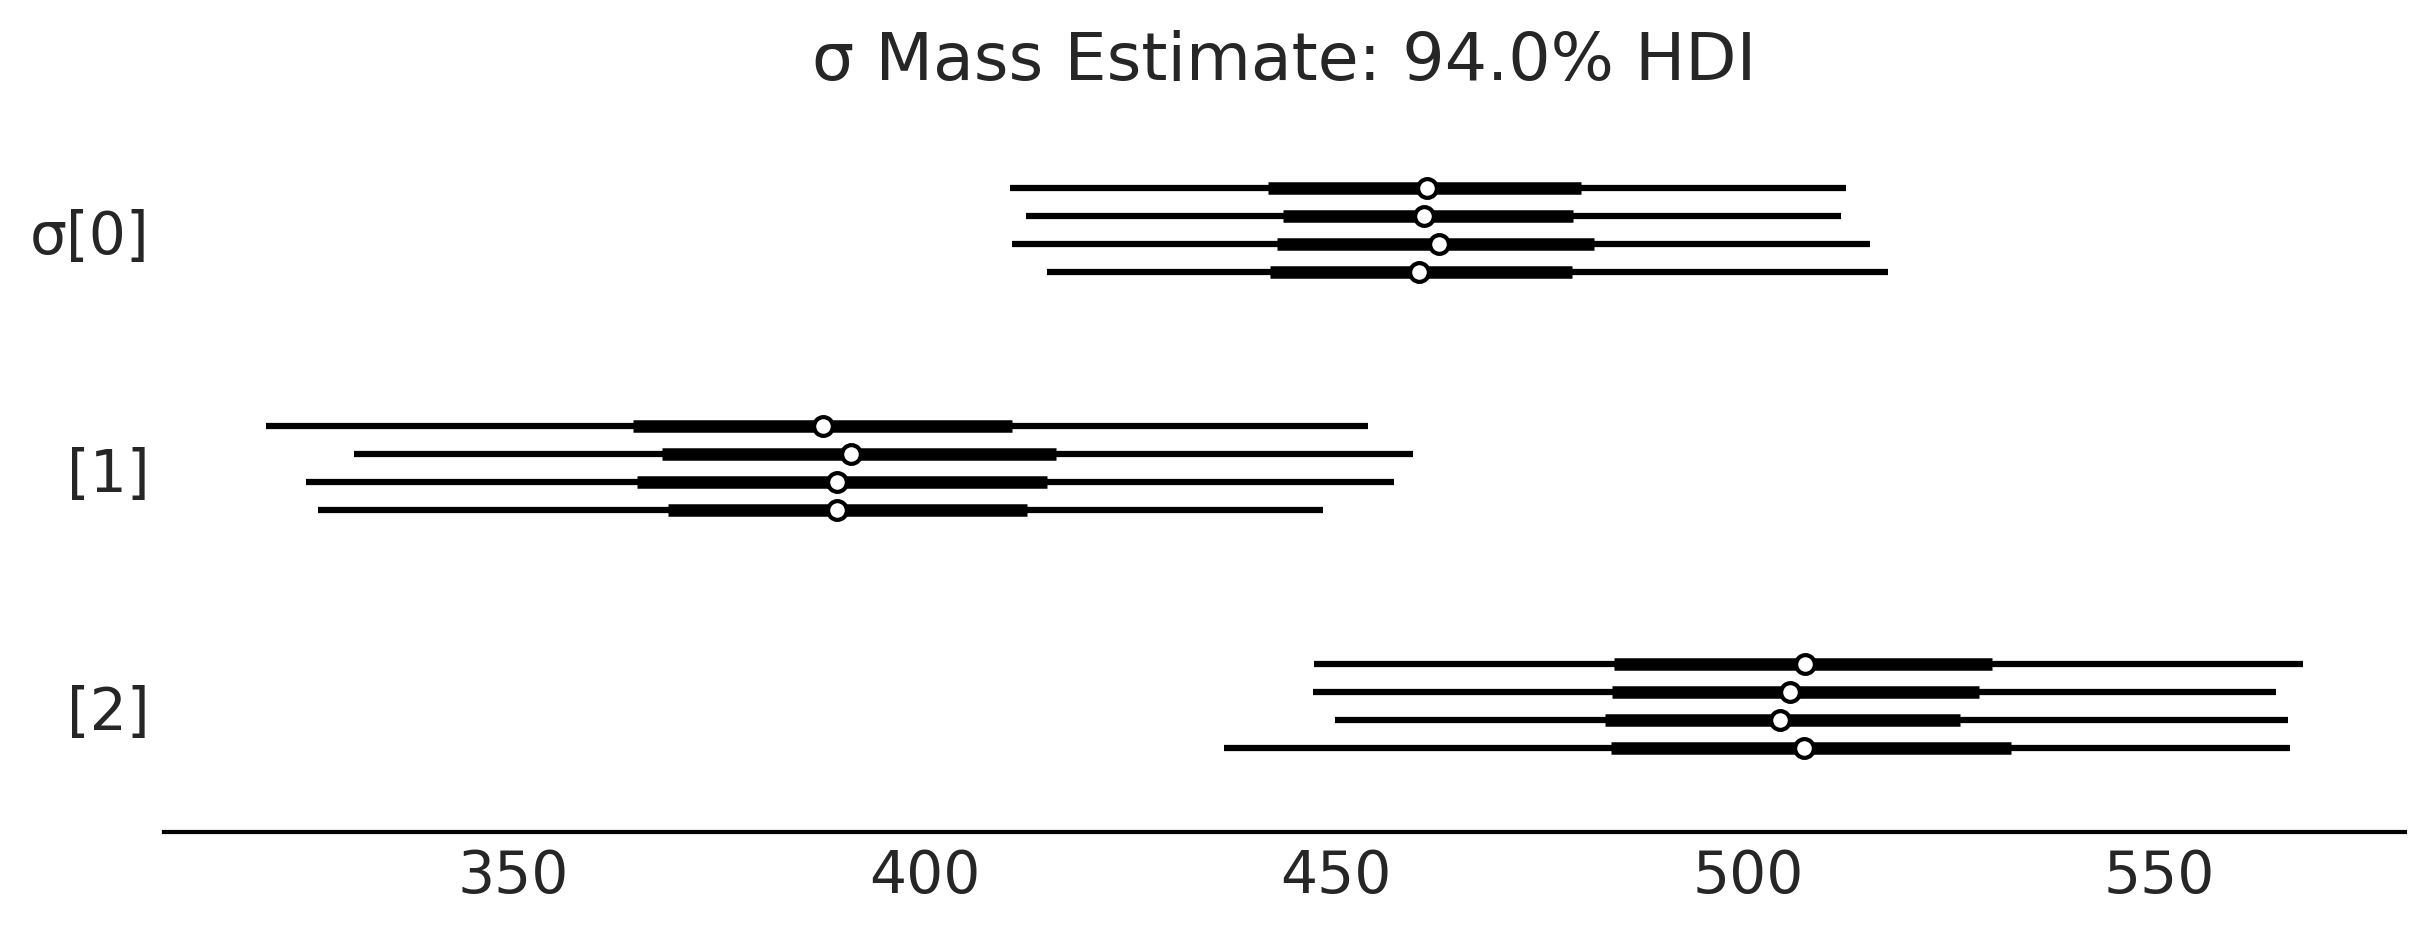

In [11]:
axes = az.plot_forest(idata_penguin_mass_all_species, var_names=["σ"], figsize=(8, 3));
axes[0].set_title("σ Mass Estimate: 94.0% HDI")

plt.savefig("img/chap03/independent_model_forestplotsigma.png")

In [12]:
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
root = tfd.JointDistributionCoroutine.Root

species_idx = tf.constant(all_species.codes, tf.int32)
body_mass_g = tf.constant(penguins["body_mass_g"], tf.float32)

@tfd.JointDistributionCoroutine
def jd_penguin_mass_all_species():
    σ = yield root(tfd.Sample(
            tfd.HalfStudentT(df=100, loc=0, scale=2000),
            sample_shape=3,
            name="sigma"))
    μ = yield root(tfd.Sample(
            tfd.Normal(loc=4000, scale=3000),
            sample_shape=3,
            name="mu"))
    mass = yield tfd.Independent(
        tfd.Normal(loc=tf.gather(μ, species_idx, axis=-1),
                   scale=tf.gather(σ, species_idx, axis=-1)),
        reinterpreted_batch_ndims=1,
        name="mass")

In [13]:
prior_predictive_samples = jd_penguin_mass_all_species.sample(1000)

In [14]:
jd_penguin_mass_all_species.sample(sigma=tf.constant([.1, .2, .3]))
jd_penguin_mass_all_species.sample(mu=tf.constant([.1, .2, .3]))

StructTuple(
  sigma=<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 289.90768, 1080.2284 , 2954.1216 ], dtype=float32)>,
  mu=<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.1, 0.2, 0.3], dtype=float32)>,
  mass=<tf.Tensor: shape=(333,), dtype=float32, numpy=
    array([-4.28325424e+01, -3.50113525e+01, -4.18534943e+02, -4.73896942e+01,
           -1.21217300e+02,  1.28867203e+02,  2.53400135e+01,  3.76623962e+02,
           -3.01964020e+02, -2.55674438e+02, -1.84210892e+02,  2.81324654e+01,
            1.29932190e+02, -4.79832214e+02, -2.03378906e+02, -3.62336845e+01,
            1.10420227e+01,  3.36081390e+01, -7.21711807e+01,  1.06901413e+02,
           -1.00755890e+02, -2.38979309e+02,  1.26016548e+02,  2.54032562e+02,
            2.43333084e+02,  2.33221039e+02,  1.85291351e+02,  4.36782471e+02,
           -5.76722145e+01,  2.49854813e+02, -3.18356171e+01, -5.05249725e+02,
           -2.38085155e+01, -8.29906921e+02, -1.26610390e+02, -3.35209503e+02,
           -5.820

In [15]:
jd_penguin_mass_all_species.sample(sigma=tf.constant([.1, .2, .3]))
jd_penguin_mass_all_species.sample(mu=tf.constant([.1, .2, .3]))

StructTuple(
  sigma=<tf.Tensor: shape=(3,), dtype=float32, numpy=array([1080.2781, 1154.4354, 2068.8987], dtype=float32)>,
  mu=<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.1, 0.2, 0.3], dtype=float32)>,
  mass=<tf.Tensor: shape=(333,), dtype=float32, numpy=
    array([ 3.64317719e+02,  8.53337646e+02, -1.15173291e+03,  1.39855505e+03,
            3.20889862e+02,  6.35086487e+02,  6.82731995e+02, -1.23811377e+03,
           -2.96955737e+03, -1.19279773e+03,  1.04707129e+03,  8.18046814e+02,
           -1.01480951e+03, -5.92292969e+02, -1.12172876e+03,  6.11852539e+02,
            1.44542773e+03, -9.60674927e+02,  4.42821350e+02, -1.24813562e+03,
            1.04999133e+03, -1.45814478e+03, -1.84218945e+03,  4.41241943e+02,
           -8.19550415e+02,  2.67905334e+02, -1.11123059e+03,  3.33620972e+02,
            6.74900391e+02, -7.77844620e+01, -7.58817978e+01,  4.54670380e+02,
           -1.06565833e+03,  6.44220398e+02,  4.85218170e+02,  1.14770251e+03,
           -1.150755

In [16]:
target_density_function = lambda *x: jd_penguin_mass_all_species.log_prob(*x, mass=body_mass_g)

In [17]:
jd_penguin_mass_observed = jd_penguin_mass_all_species.experimental_pin(mass=body_mass_g)
target_density_function = jd_penguin_mass_observed.unnormalized_log_prob

In [18]:
# MCMC chains

run_mcmc = tf.function(
    tfp.experimental.mcmc.windowed_adaptive_nuts,
    autograph=False, jit_compile=True)

mcmc_samples, sampler_stats = run_mcmc(1000, jd_penguin_mass_all_species, n_chains=4, num_adaptation_steps=100, 
                                       mass=body_mass_g)

idata_penguin_mass_all_species2 = az.from_dict(
    posterior={
        # TFP mcmc returns (num_samples, num_chains, ...), we swap
        # the first and second axis below for each RV so the shape 
        # is what ArviZ expected.
        k:np.swapaxes(v, 1, 0)
        for k, v in mcmc_samples._asdict().items()},
        sample_stats={
        k:np.swapaxes(sampler_stats[k], 1, 0)
        for k in ["target_log_prob", "diverging", "accept_ratio", "n_steps"]}
)

I0000 00:00:1718390714.689299 35525681 service.cc:145] XLA service 0x60000daef600 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1718390714.689322 35525681 service.cc:153]   StreamExecutor device (0): Host, Default Version
W0000 00:00:1718390714.909677 35525681 random_ops.cc:105] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. sanitize_seed/seed
W0000 00:00:1718390715.008182 35525681 assert_op.cc:38] Ignoring Assert operator mcmc_retry_init/assert_equal_1/Assert/AssertGuard/Assert
I0000 00:00:1718390720.527861 35525681 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


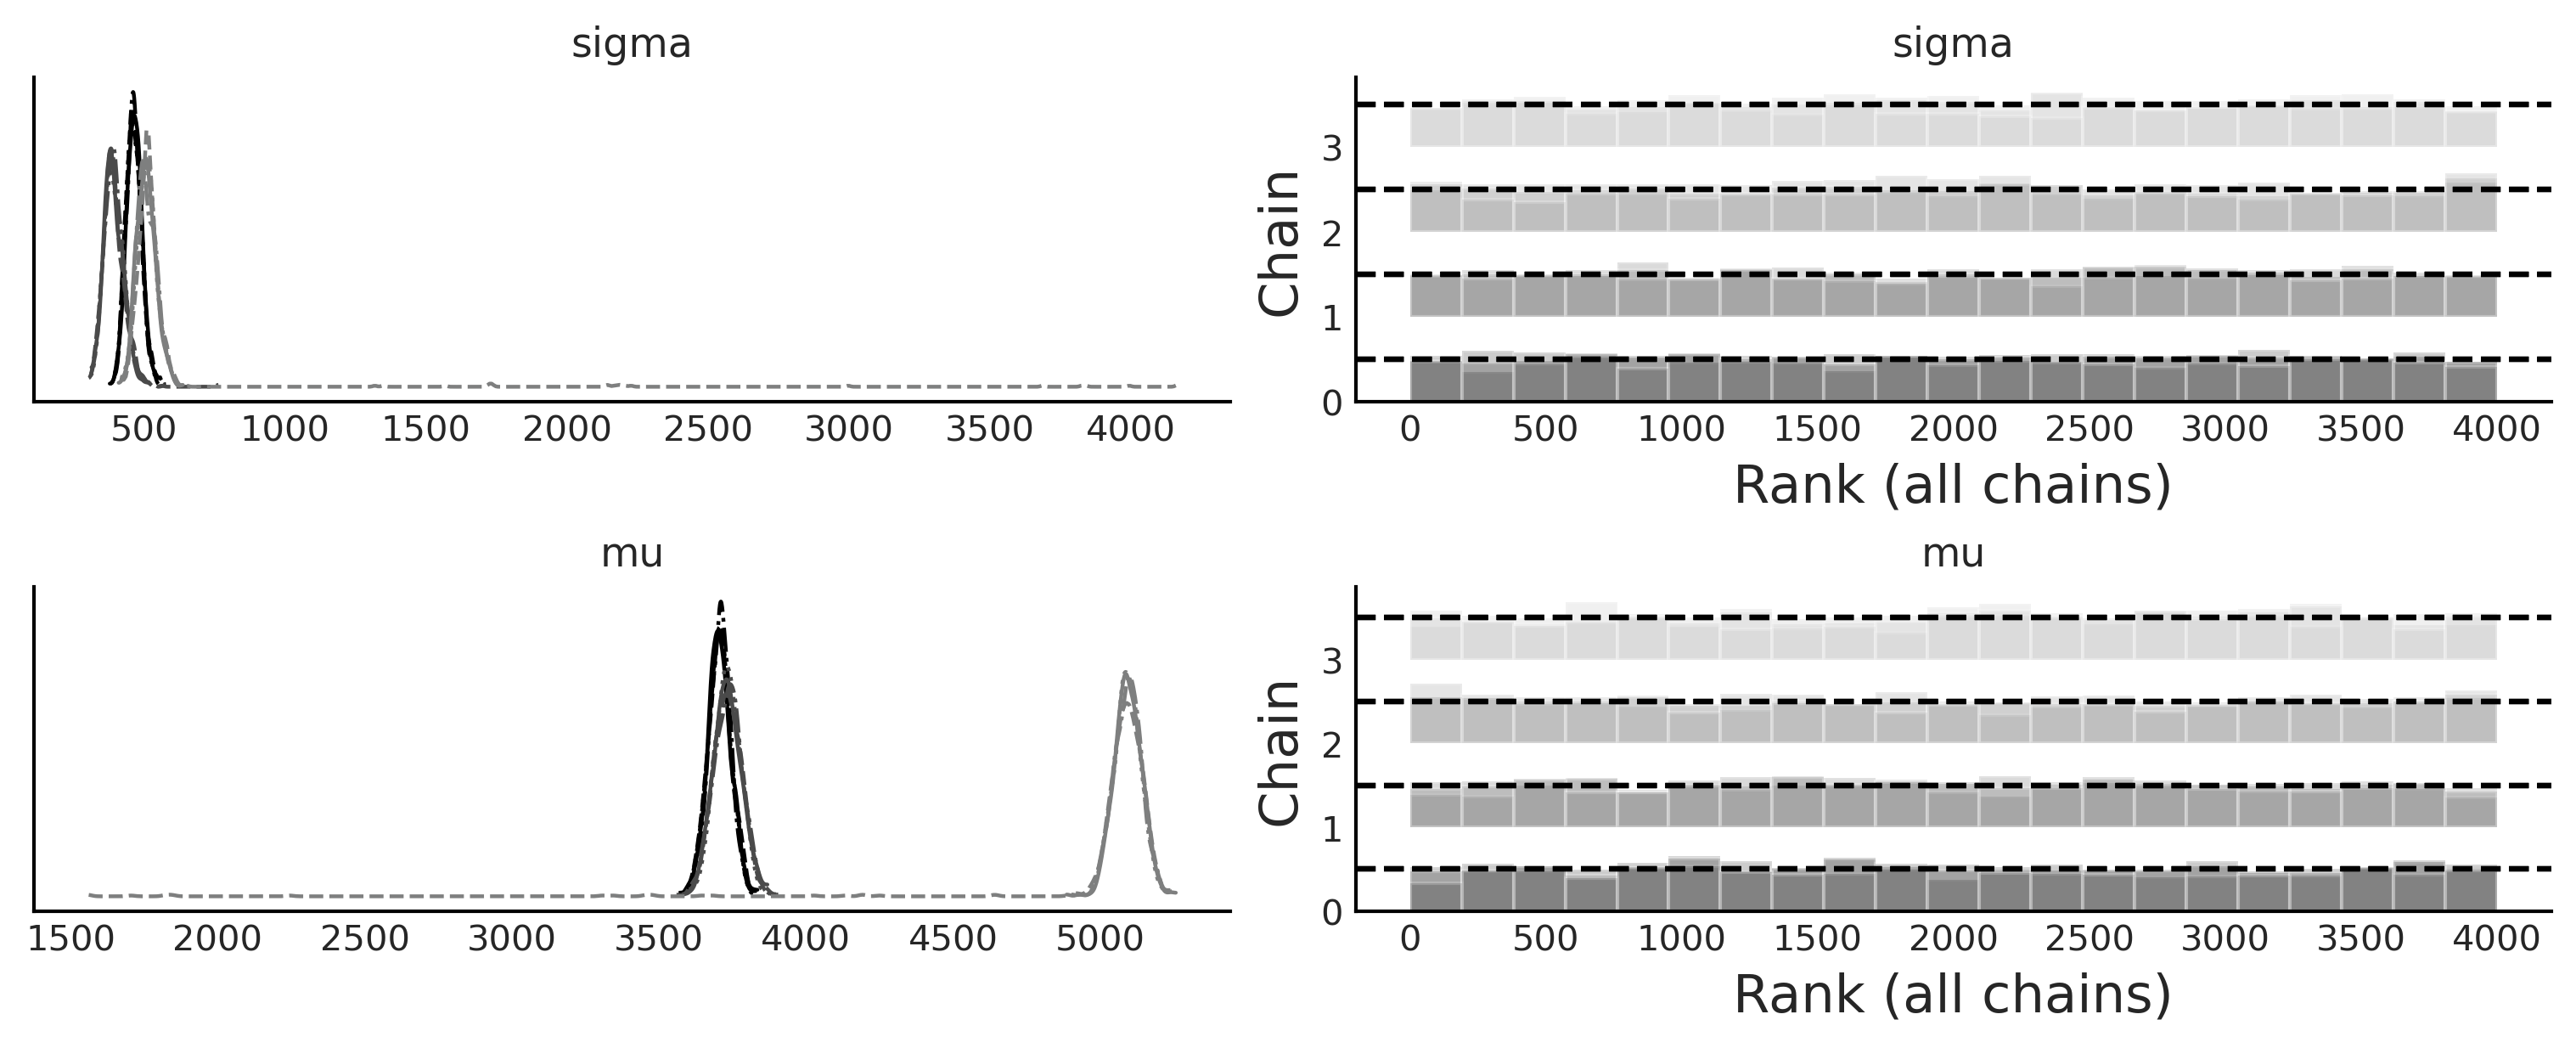

In [19]:
az.plot_trace(idata_penguin_mass_all_species2, divergences="bottom", kind="rank_bars", figsize=(10,4));

In [20]:
prior_predictive_samples = jd_penguin_mass_all_species.sample([1, 1000])
dist, samples = jd_penguin_mass_all_species.sample_distributions(
    value=mcmc_samples)
ppc_samples = samples[-1]
ppc_distribution = dist[-1].distribution
data_log_likelihood = ppc_distribution.log_prob(body_mass_g)

# Be careful not to run this code twice during REPL workflow.
idata_penguin_mass_all_species2.add_groups(
    prior=prior_predictive_samples[:-1]._asdict(),
    prior_predictive={"mass": prior_predictive_samples[-1]},
    posterior_predictive={"mass": np.swapaxes(ppc_samples, 1, 0)},
    log_likelihood={"mass": np.swapaxes(data_log_likelihood, 1, 0)},
    observed_data={"mass": body_mass_g}
)

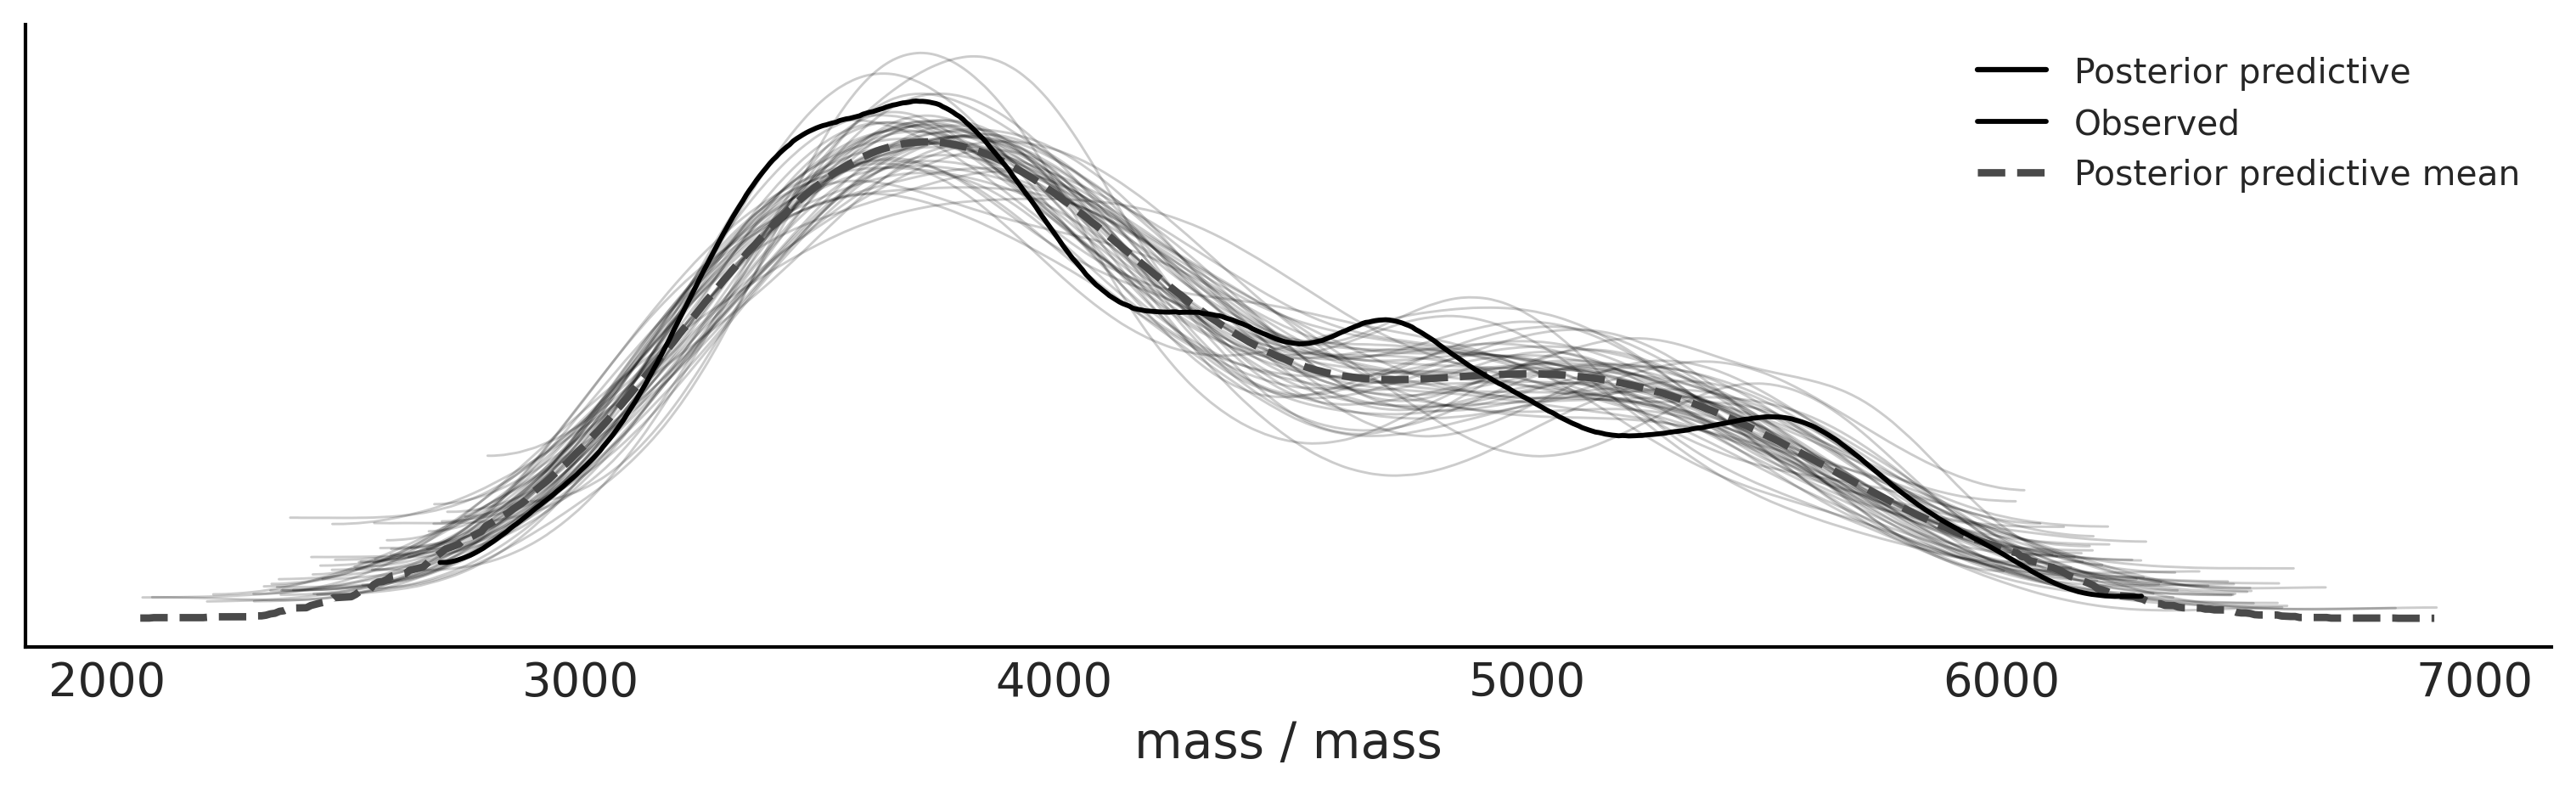

In [21]:
az.plot_ppc(idata_penguin_mass_all_species2, num_pp_samples=50, figsize=(10, 3));

### Code 3.13

In [22]:
adelie_flipper_length_obs = penguins.loc[adelie_mask, "flipper_length_mm"]

with pm.Model() as model_adelie_flipper_regression:
    # pm.Data allows us to change the underlying value in a later code block
    adelie_flipper_length = pm.MutableData("adelie_flipper_length", adelie_flipper_length_obs)
    σ = pm.HalfStudentT("σ", 100, 2000)
    β_0 = pm.Normal("β_0", 0, 4000)
    β_1 = pm.Normal("β_1", 0, 4000)
    μ = pm.Deterministic("μ", β_0 + β_1 * adelie_flipper_length)

    mass = pm.Normal("mass", mu=μ, sigma=σ, observed=adelie_mass_obs)

    idata_adelie_flipper_regression = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β_0, β_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


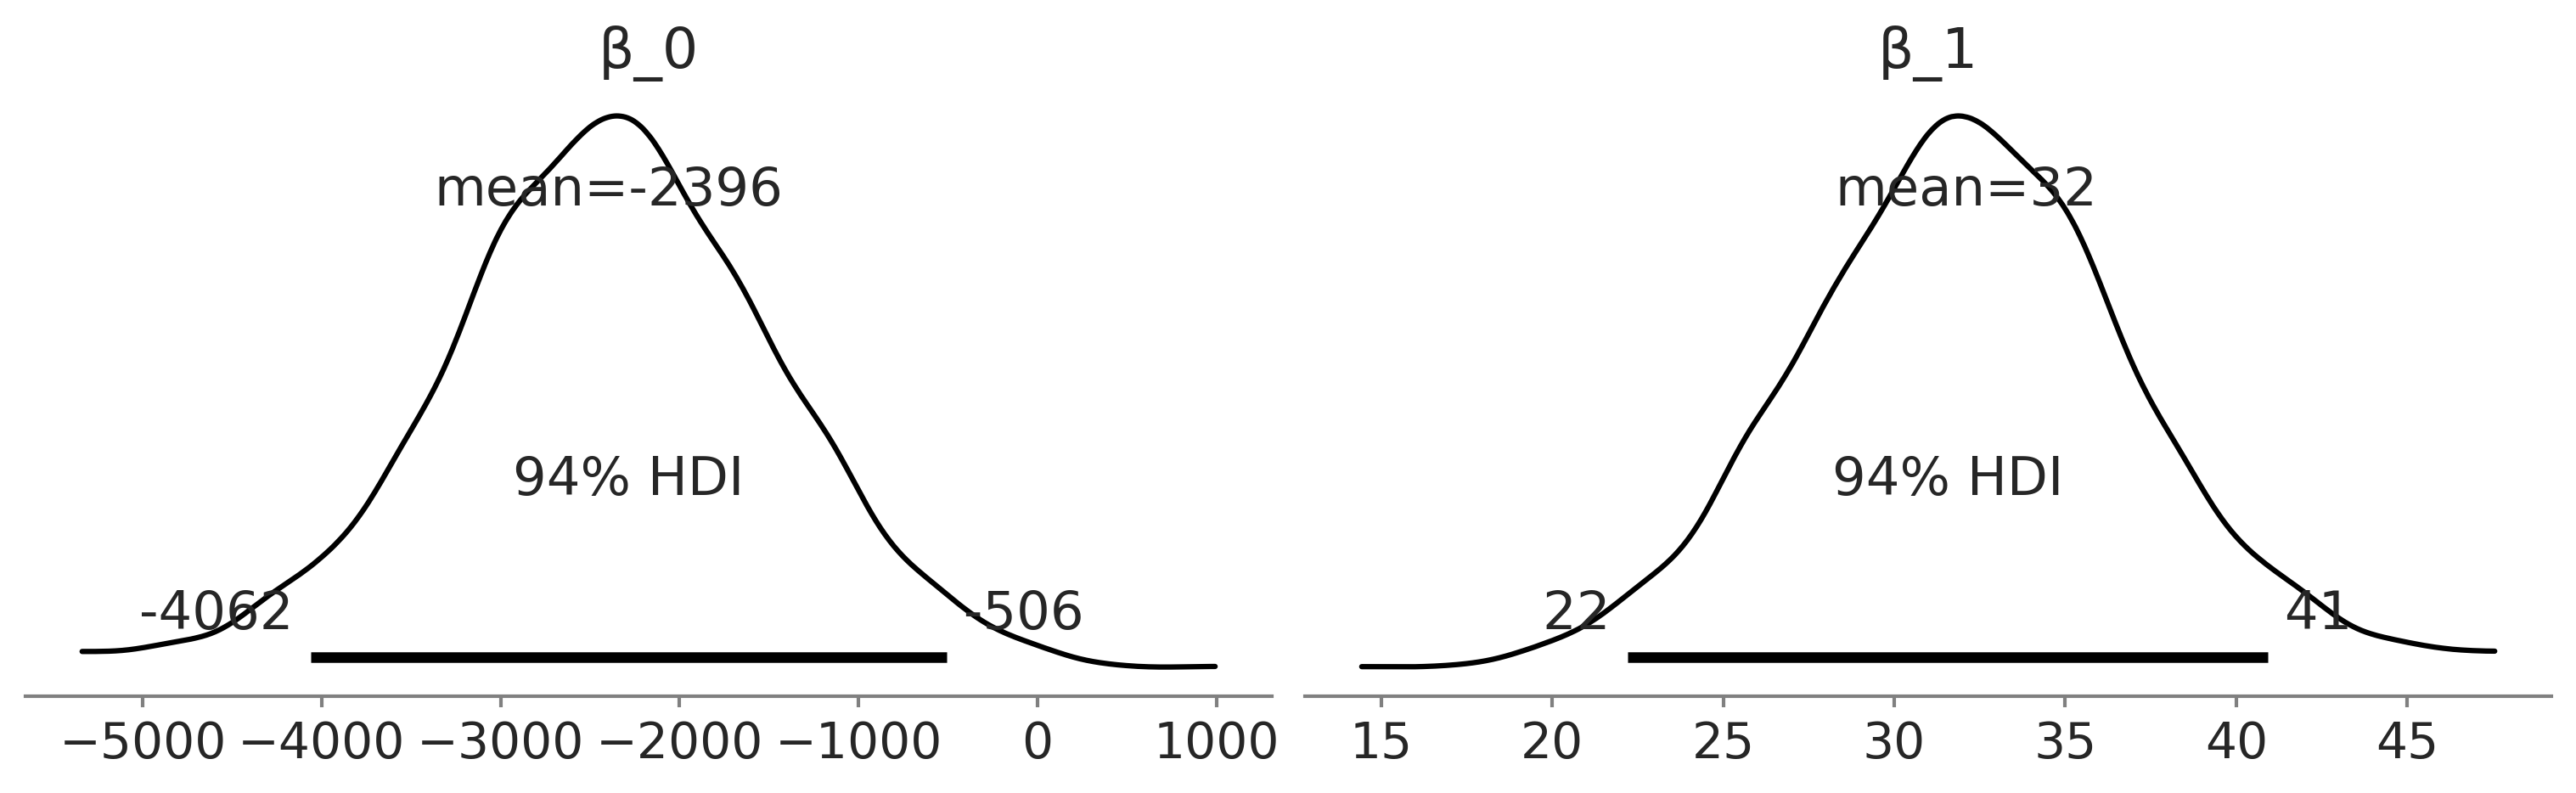

In [23]:
axes = az.plot_posterior(idata_adelie_flipper_regression, var_names = ["β_0", "β_1"], figsize=(10, 3));

plt.savefig("img/chap03/adelie_coefficient_posterior_plots")

### Code 3.14

In [24]:
with model_adelie_flipper_regression:
    # Change the underlying value to the mean observed flipper length
    # for our posterior predictive samples
    pm.set_data({"adelie_flipper_length": [adelie_flipper_length_obs.mean()]})
    posterior_predictions = pm.sample_posterior_predictive(
        idata_adelie_flipper_regression.posterior, var_names=["mass", "μ"])

Sampling: [mass]


## Centering


In [25]:
adelie_flipper_length_c = adelie_flipper_length_obs - adelie_flipper_length_obs.mean()

In [26]:
def gen_adelie_flipper_model(adelie_flipper_length):
    adelie_flipper_length = tf.constant(adelie_flipper_length, tf.float32)

    @tfd.JointDistributionCoroutine
    def jd_adelie_flipper_regression():
        σ = yield root(tfd.HalfStudentT(df=100, loc=0, scale=2000, name='sigma'))
        β_1 = yield root(tfd.Normal(loc=0, scale=4000, name='beta_1'))
        β_0 = yield root(tfd.Normal(loc=0, scale=4000, name='beta_0'))
        μ = β_0[..., None] + β_1[..., None] * adelie_flipper_length
        mass = yield tfd.Independent(
            tfd.Normal(loc=μ, scale=σ[..., None]),
            reinterpreted_batch_ndims=1,
            name='mass')

    return jd_adelie_flipper_regression


# Use non-centered predictor, this gives the same model as
# model_adelie_flipper_regression
jd_adelie_flipper_regression = gen_adelie_flipper_model(
    adelie_flipper_length_obs)

# Use centered predictor
jd_adelie_flipper_regression = gen_adelie_flipper_model(
    adelie_flipper_length_c)

mcmc_samples, sampler_stats = run_mcmc(
    1000, jd_adelie_flipper_regression, n_chains=4, num_adaptation_steps=1000,
    mass=tf.constant(adelie_mass_obs, tf.float32))

inf_data_adelie_flipper_length_c = az.from_dict(
    posterior={
        k:np.swapaxes(v, 1, 0)
        for k, v in mcmc_samples._asdict().items()},
    sample_stats={
        k:np.swapaxes(sampler_stats[k], 1, 0)
        for k in ["target_log_prob", "diverging", "accept_ratio", "n_steps"]
    }
)

W0000 00:00:1718390738.409600 35525681 assert_op.cc:38] Ignoring Assert operator mcmc_retry_init/assert_equal_1/Assert/AssertGuard/Assert


array([<Axes: title={'center': 'beta_0'}>,
       <Axes: title={'center': 'beta_1'}>], dtype=object)

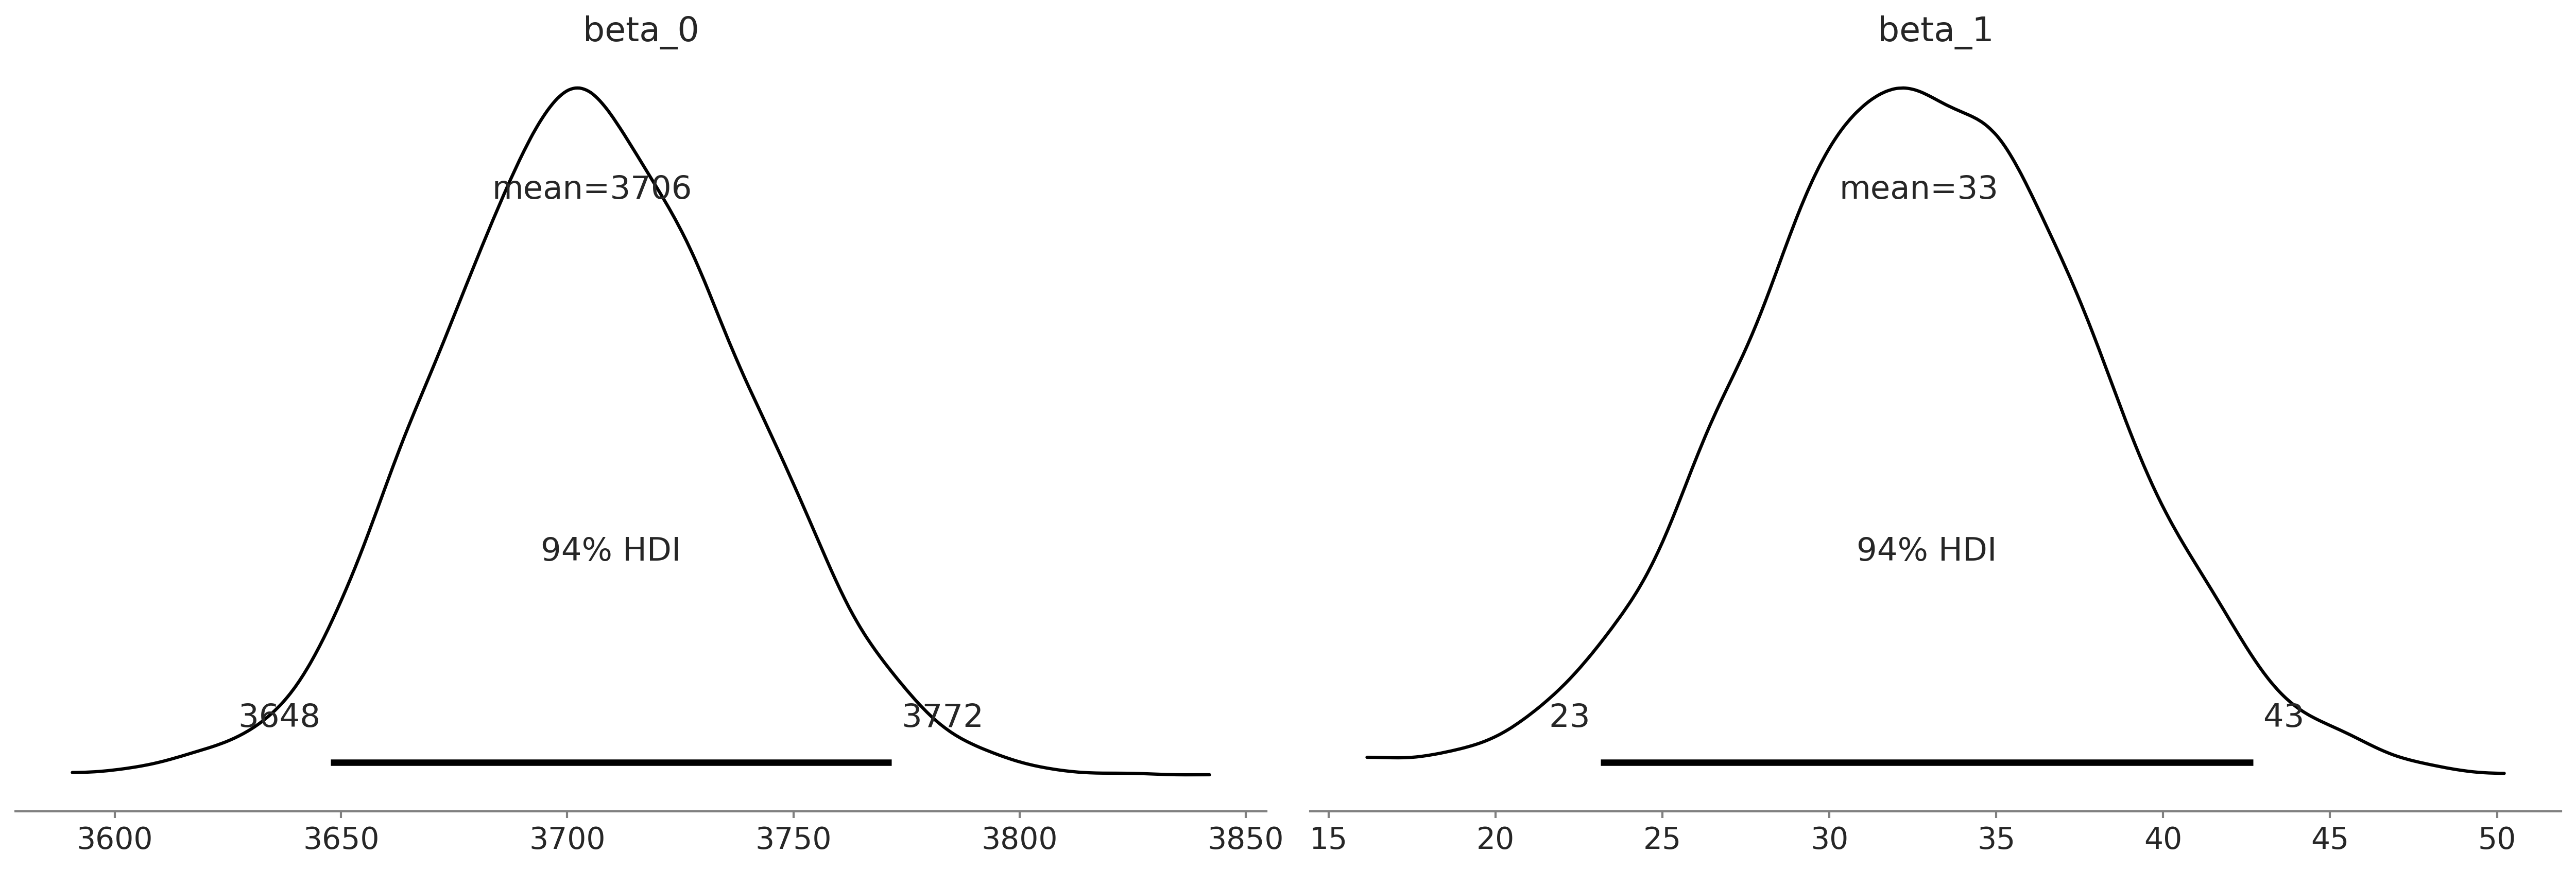

In [27]:
az.plot_posterior(inf_data_adelie_flipper_length_c, var_names=["beta_0", "beta_1"])

## Multiple Linear Regression

In [28]:
# Binary encoding of the categorical predictor
sex_obs = penguins.loc[adelie_mask, "sex"].replace({"male":0, "female":1})

with pm.Model() as model_penguin_mass_categorical:
    σ = pm.HalfStudentT("σ", 100, 2000)
    β_0 = pm.Normal("β_0", 0, 3000)
    β_1 = pm.Normal("β_1", 0, 3000)
    β_2 = pm.Normal("β_2", 0, 3000)

    μ = pm.Deterministic("μ", β_0 + β_1 * adelie_flipper_length_obs + β_2 * sex_obs)

    mass = pm.Normal("mass", mu=μ, sigma=σ, observed=adelie_mass_obs)

    inf_data_penguin_mass_categorical = pm.sample(target_accept=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β_0, β_1, β_2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


array([<Axes: title={'center': 'β_0'}>, <Axes: title={'center': 'β_1'}>,
       <Axes: title={'center': 'β_2'}>, <Axes: title={'center': 'σ'}>],
      dtype=object)

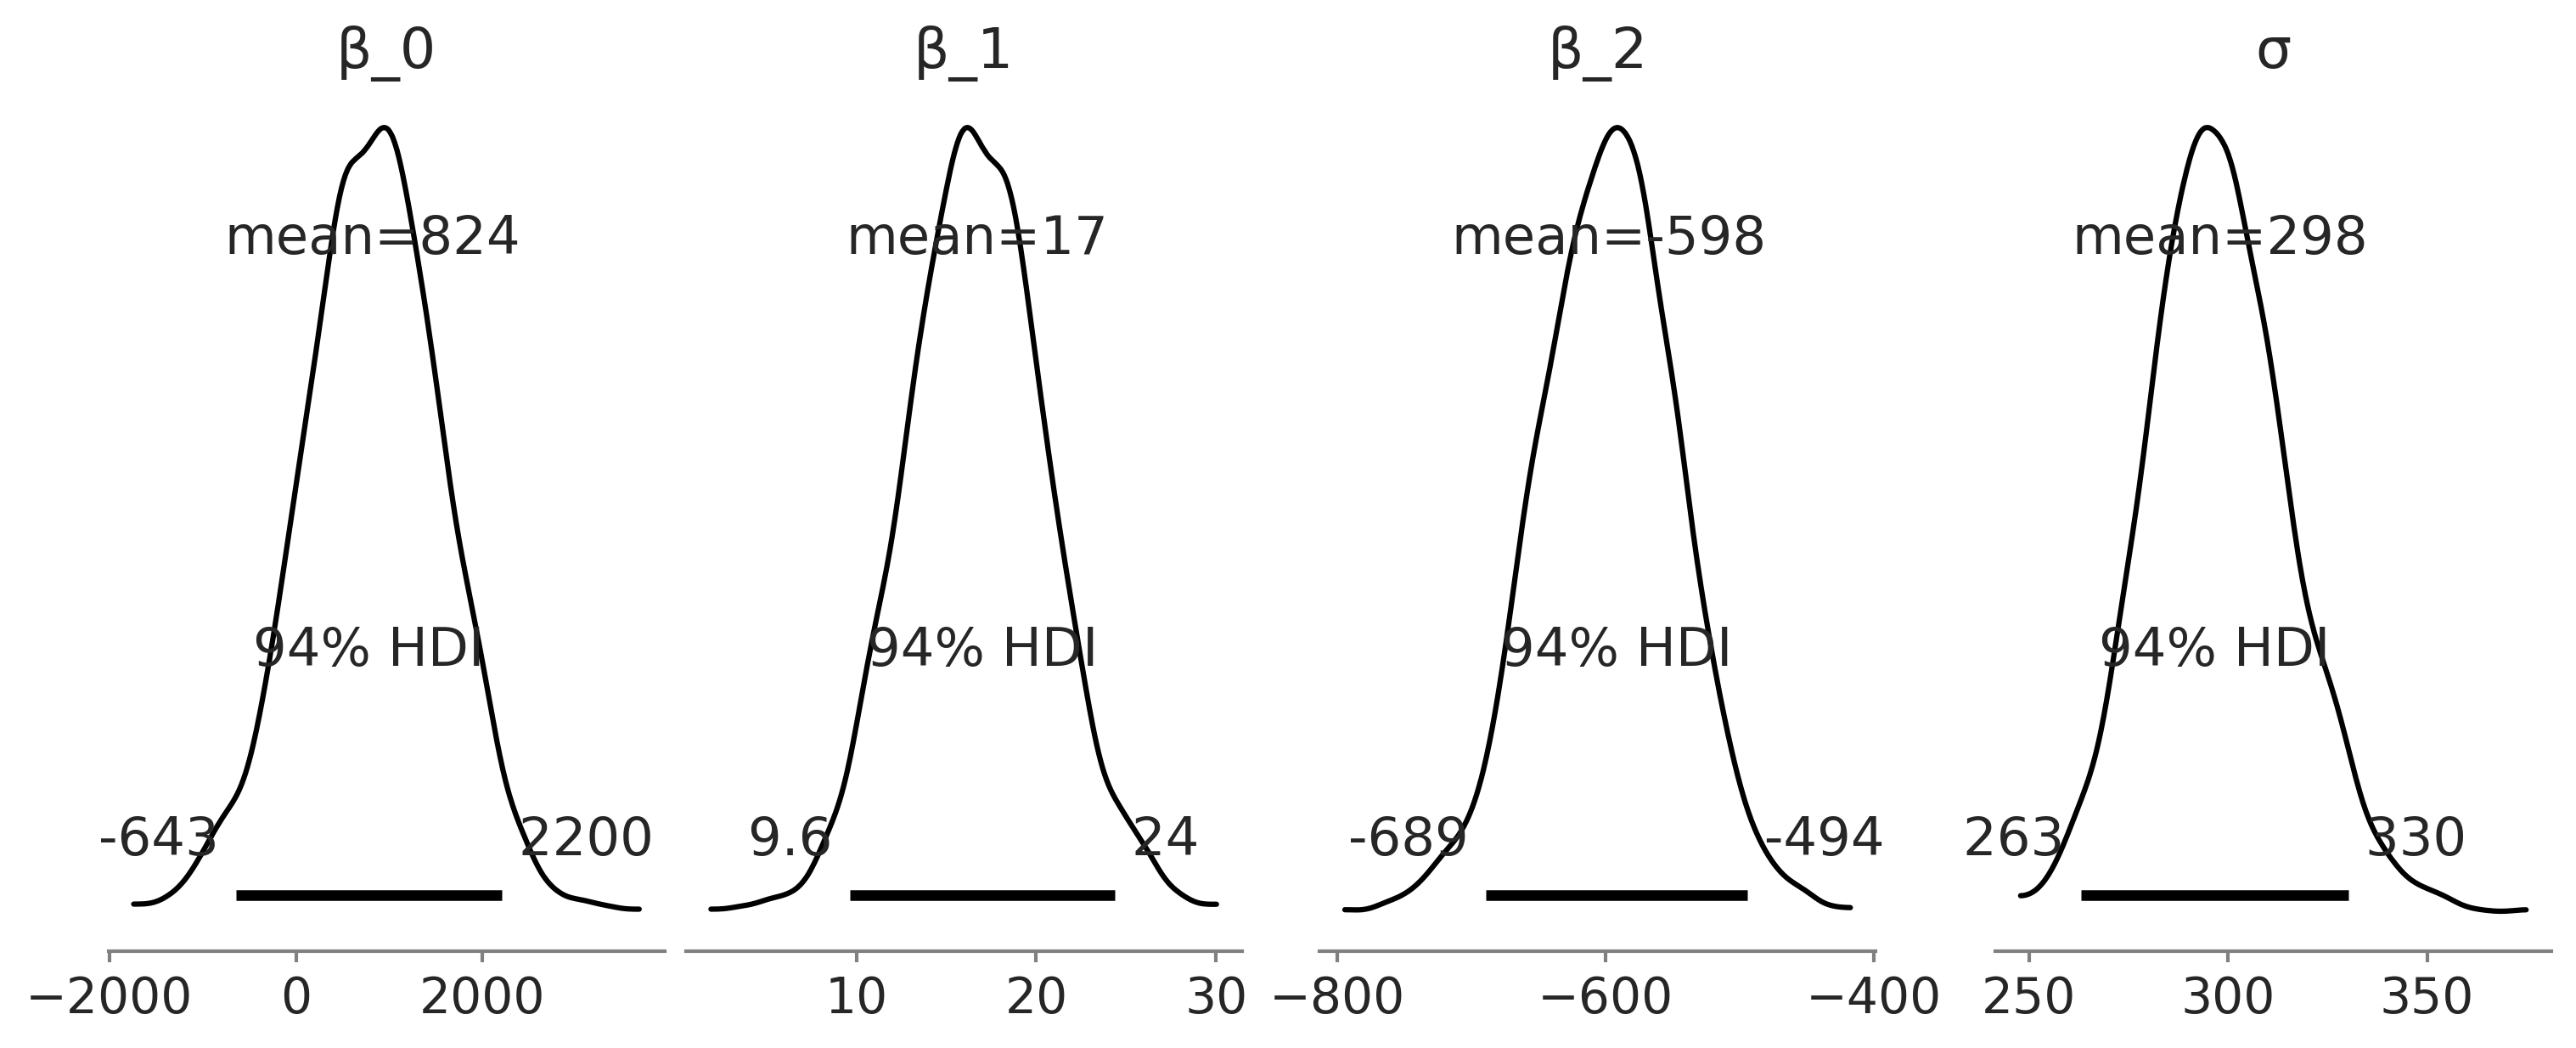

In [29]:
az.plot_posterior(inf_data_penguin_mass_categorical, var_names=["β_0", "β_1", "β_2", "σ"], figsize=(10, 4))

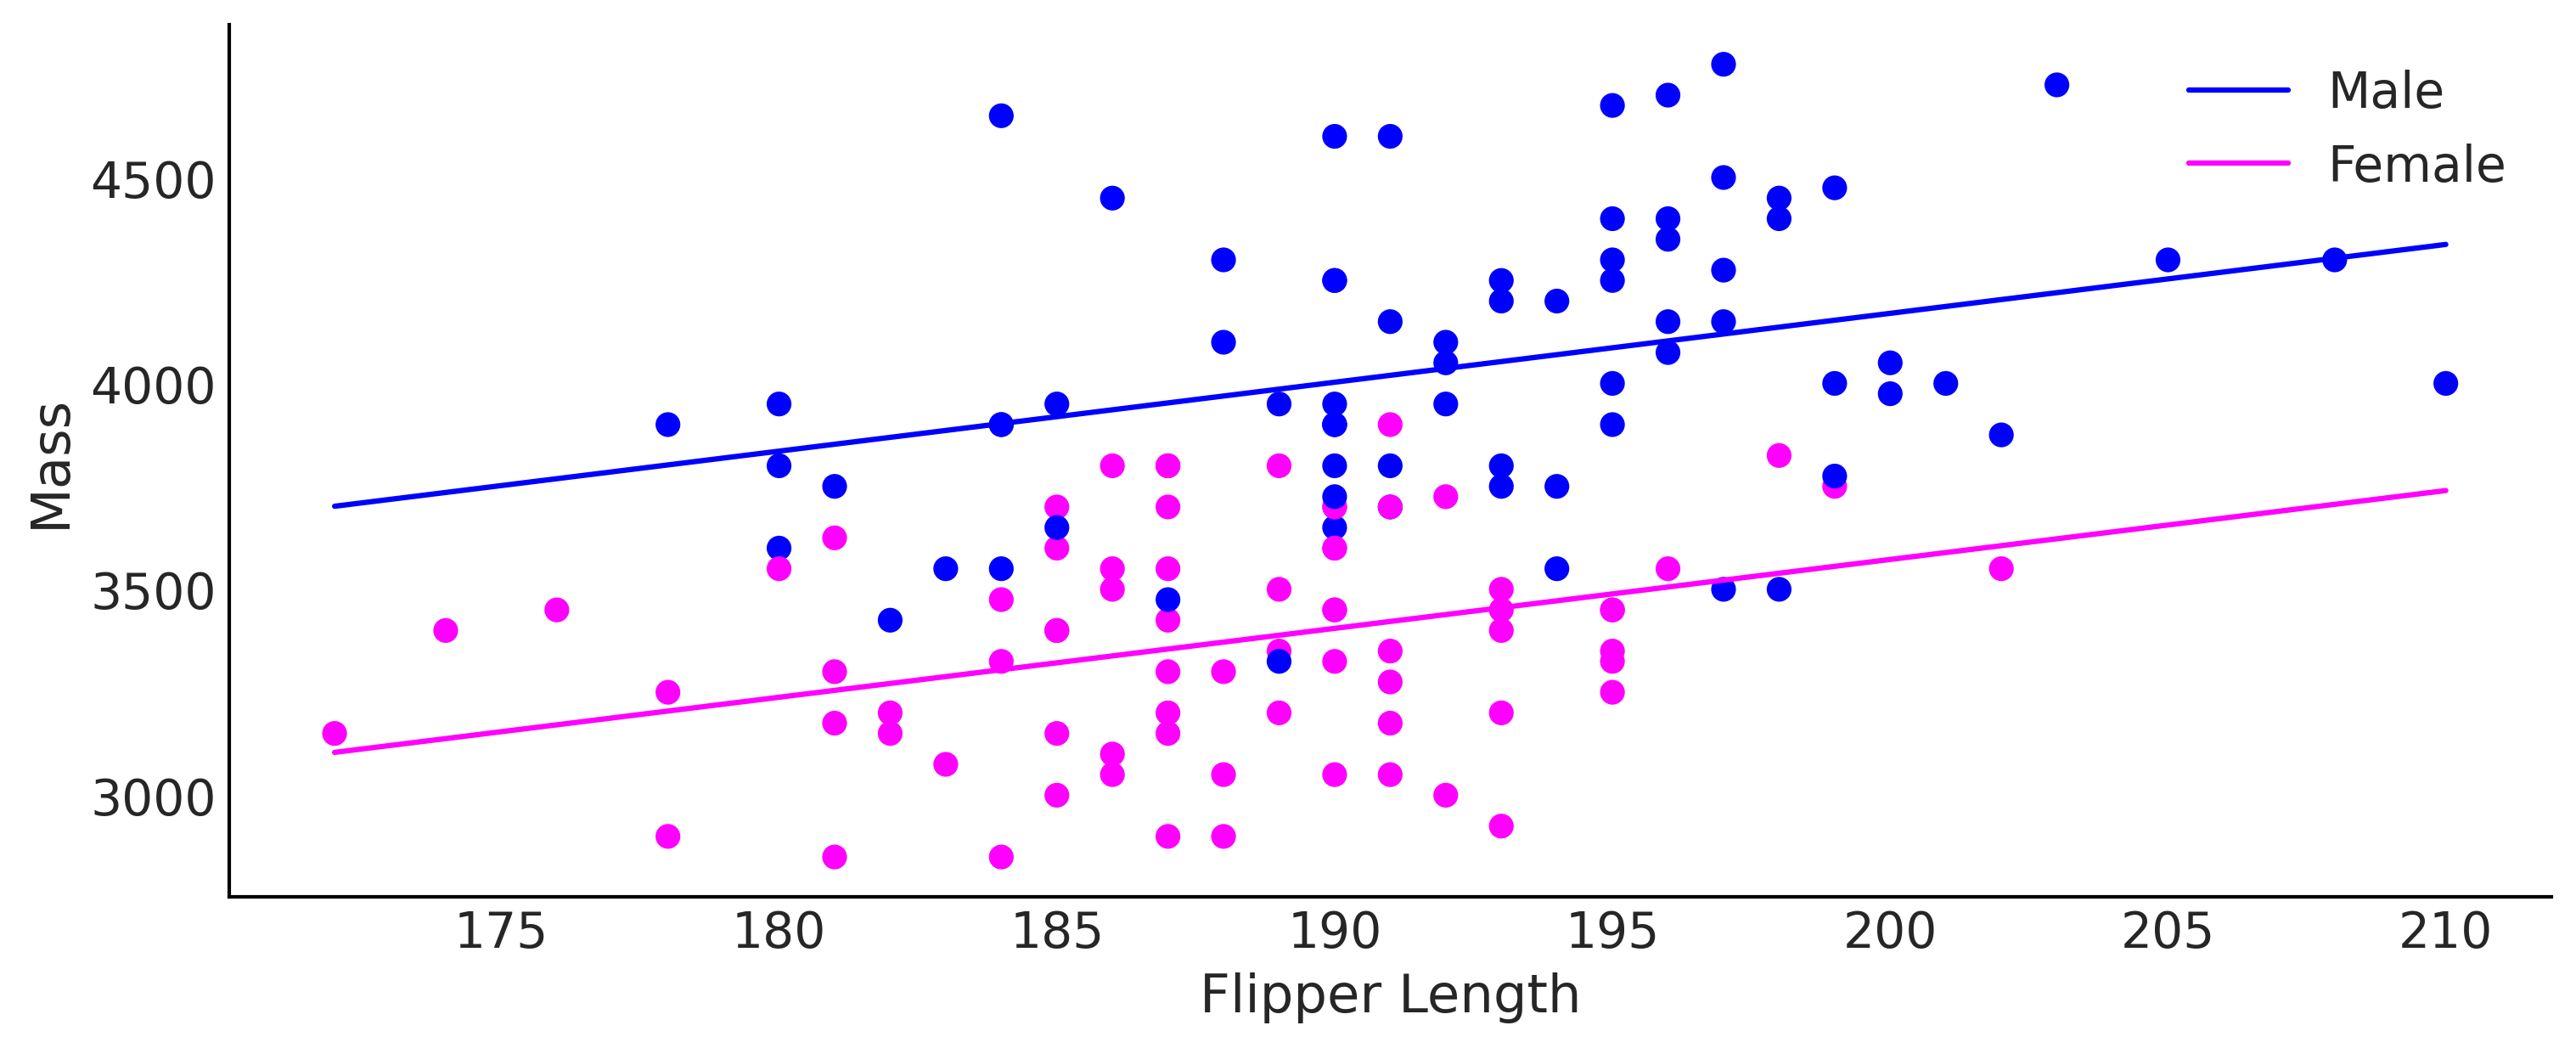

In [30]:
fig, ax = plt.subplots(figsize=(10, 4))
alpha_1 = inf_data_penguin_mass_categorical.posterior["β_0"].mean().item()
beta_1 = inf_data_penguin_mass_categorical.posterior["β_1"].mean().item()
beta_2 = inf_data_penguin_mass_categorical.posterior["β_2"].mean().item()


flipper_length = np.linspace(adelie_flipper_length_obs.min(), adelie_flipper_length_obs.max(), 100)

mass_mean_male = alpha_1 + beta_1 * flipper_length
mass_mean_female = alpha_1 + beta_1 * flipper_length + beta_2

ax.plot(flipper_length, mass_mean_male,
         label="Male", c='blue')

ax.plot(flipper_length, mass_mean_female, c='magenta',
         label="Female")

ax.scatter(adelie_flipper_length_obs, adelie_mass_obs, c=[{0:"blue", 1:"magenta"}[code] for code in sex_obs.values])

# Figure out how to do this from inference data
#az.plot_hpd(adelie_flipper_length, trace.get_values(varname="μ"), credible_interval=0.94, color='k', ax=ax)

ax.set_xlabel('Flipper Length')
ax.set_ylabel('Mass');
ax.legend()
plt.savefig("img/chap03/single_species_categorical_regression.png")

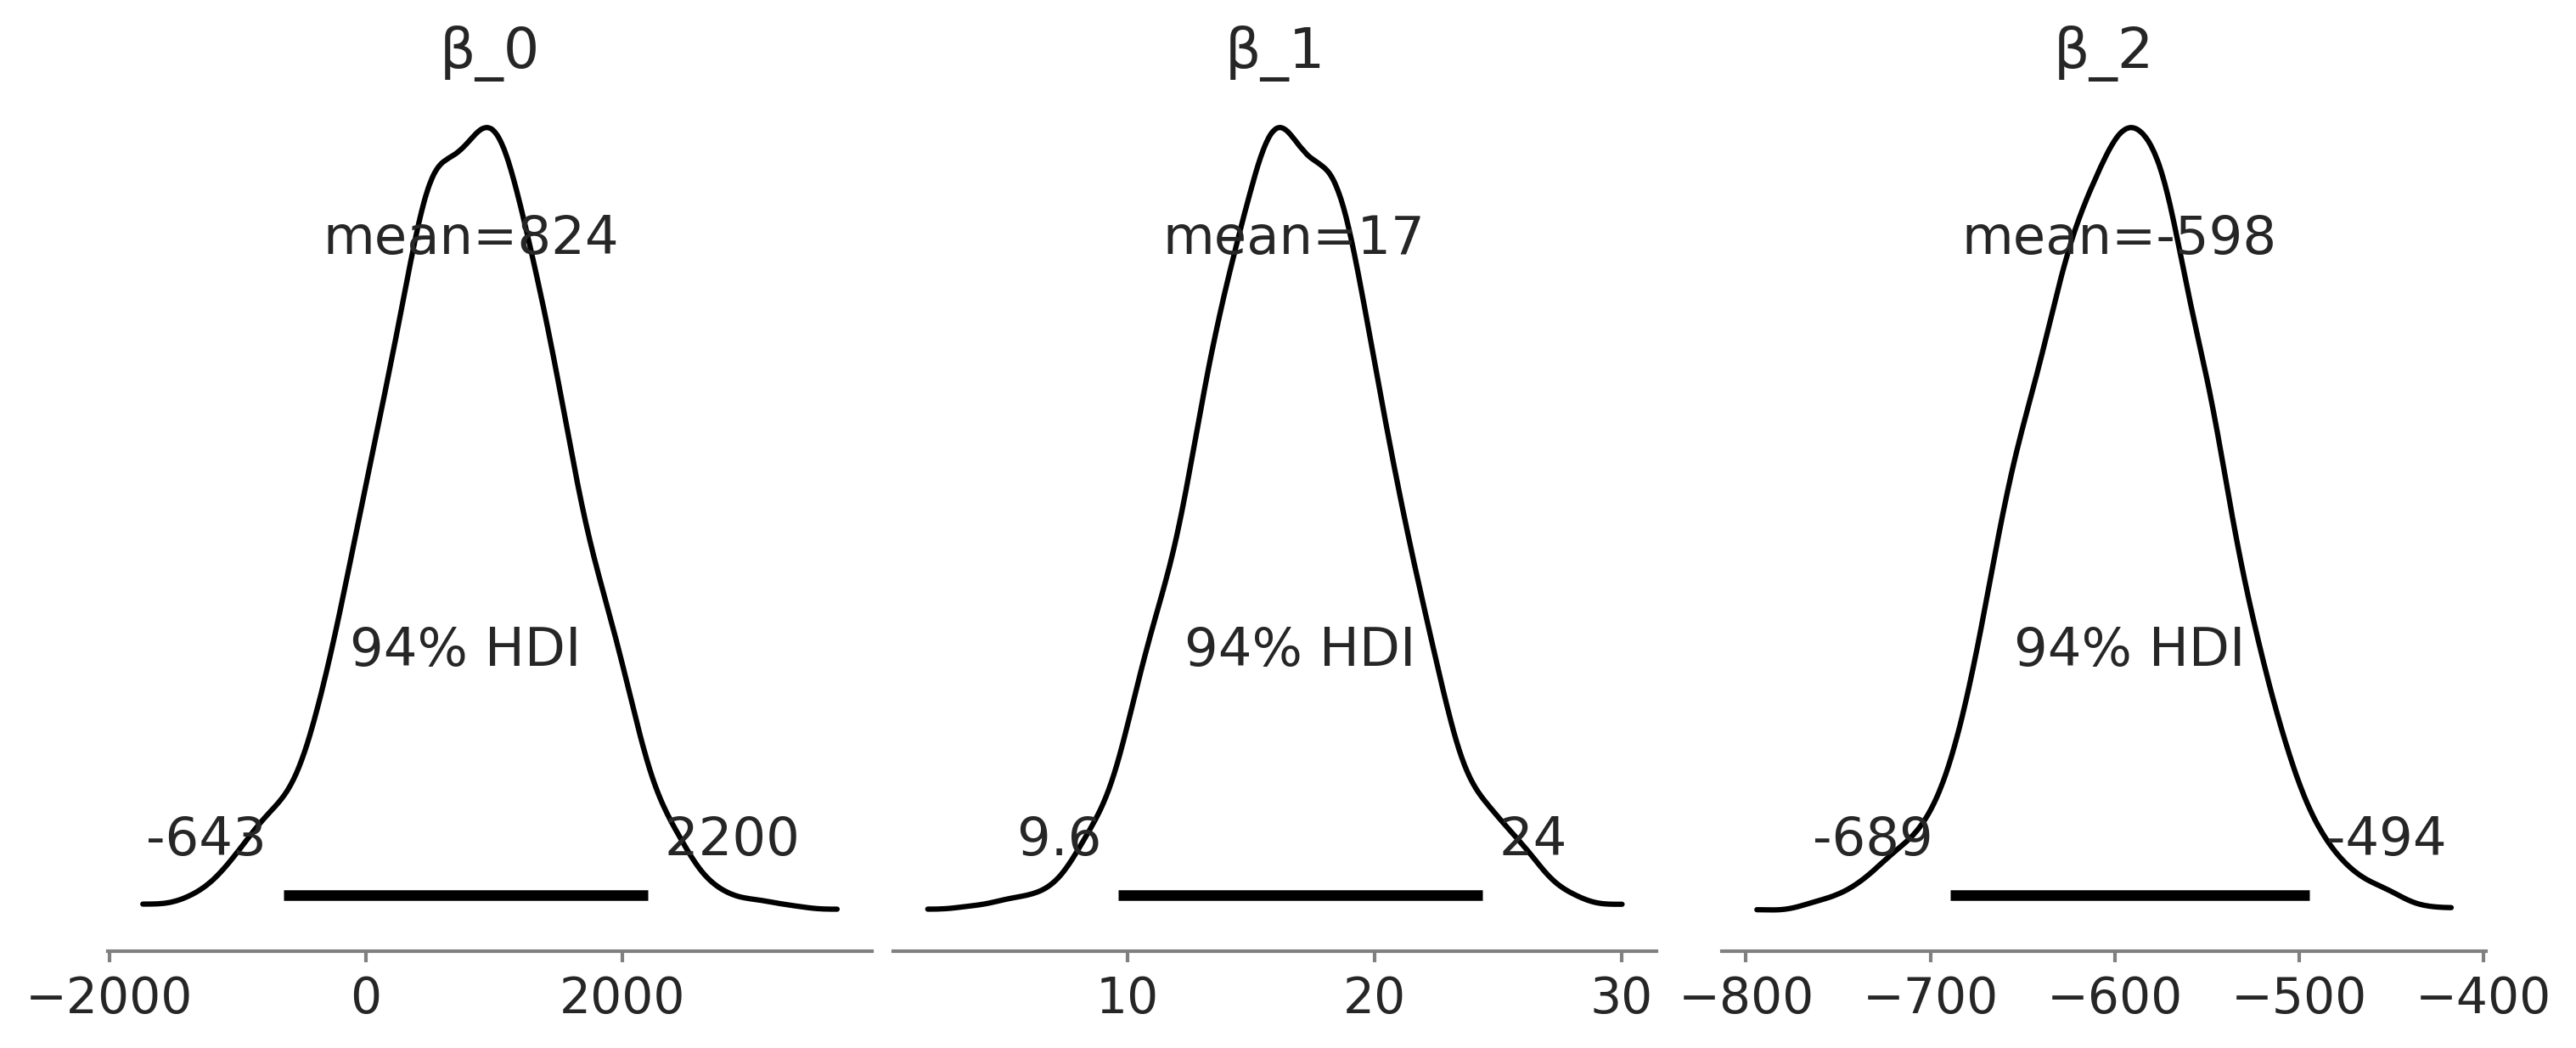

In [31]:
az.plot_posterior(inf_data_penguin_mass_categorical, var_names=["β_0", "β_1", "β_2"], figsize=(10, 4))
plt.savefig("img/chap03/adelie_sex_coefficient_posterior.png")

In [32]:
az.summary(inf_data_penguin_mass_categorical, var_names=["β_0","β_1","β_2", "σ"])

mean       sd   hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
β_0  823.885  752.874 -642.603  2200.494     20.929   14.803    1296.0   
β_1   16.731    3.908    9.622    24.379      0.108    0.076    1309.0   
β_2 -597.665   51.999 -689.160  -494.310      1.215    0.863    1847.0   
σ    297.893   17.791  263.122   330.228      0.355    0.252    2562.0   

     ess_tail  r_hat  
β_0    1612.0    1.0  
β_1    1606.0    1.0  
β_2    1871.0    1.0  
σ      2336.0    1.0

### 3.3.1 Counterfactuals

In [33]:
# Extension of previous linear regression with extra param, bill_length
def gen_jd_flipper_bill_sex(flipper_length, sex, bill_length, dtype=tf.float32):
    flipper_length, sex, bill_length = tf.nest.map_structure(
        lambda x: tf.constant(x, dtype),
        (flipper_length, sex, bill_length)
    )

    @tfd.JointDistributionCoroutine
    def jd_flipper_bill_sex():
        σ = yield root(
            tfd.HalfStudentT(df=100, loc=0, scale=2000, name="sigma"))
        β_0 = yield root(tfd.Normal(loc=0, scale=3000, name="beta_0"))
        β_1 = yield root(tfd.Normal(loc=0, scale=3000, name="beta_1"))
        β_2 = yield root(tfd.Normal(loc=0, scale=3000, name="beta_2"))
        β_3 = yield root(tfd.Normal(loc=0, scale=3000, name="beta_3"))
        μ = (β_0[..., None]
             + β_1[..., None] * flipper_length
             + β_2[..., None] * sex
             + β_3[..., None] * bill_length
            )
        mass = yield tfd.Independent(
            tfd.Normal(loc=μ, scale=σ[..., None]),
            reinterpreted_batch_ndims=1,
            name="mass")

    return jd_flipper_bill_sex

bill_length_obs = penguins.loc[adelie_mask, "bill_length_mm"]
jd_flipper_bill_sex = gen_jd_flipper_bill_sex(
    adelie_flipper_length_obs, sex_obs, bill_length_obs)

mcmc_samples, sampler_stats = run_mcmc(
    1000, jd_flipper_bill_sex, n_chains=4, num_adaptation_steps=1000,
    mass=tf.constant(adelie_mass_obs, tf.float32))

W0000 00:00:1718390771.253929 35525681 assert_op.cc:38] Ignoring Assert operator mcmc_retry_init/assert_equal_1/Assert/AssertGuard/Assert


In [34]:
idata_model_penguin_flipper_bill_sex = az.from_dict(
    posterior = {
        k: np.swapaxes(v, 1, 0)
        for k,v in mcmc_samples._asdict().items()},
        sample_stats = {
            k: np.swapaxes(sampler_stats[k], 1, 0)
            for k in ["target_log_prob", "diverging", "accept_ratio", "n_steps"]
        }
)

array([<Axes: title={'center': 'beta_1'}>,
       <Axes: title={'center': 'beta_2'}>,
       <Axes: title={'center': 'beta_3'}>], dtype=object)

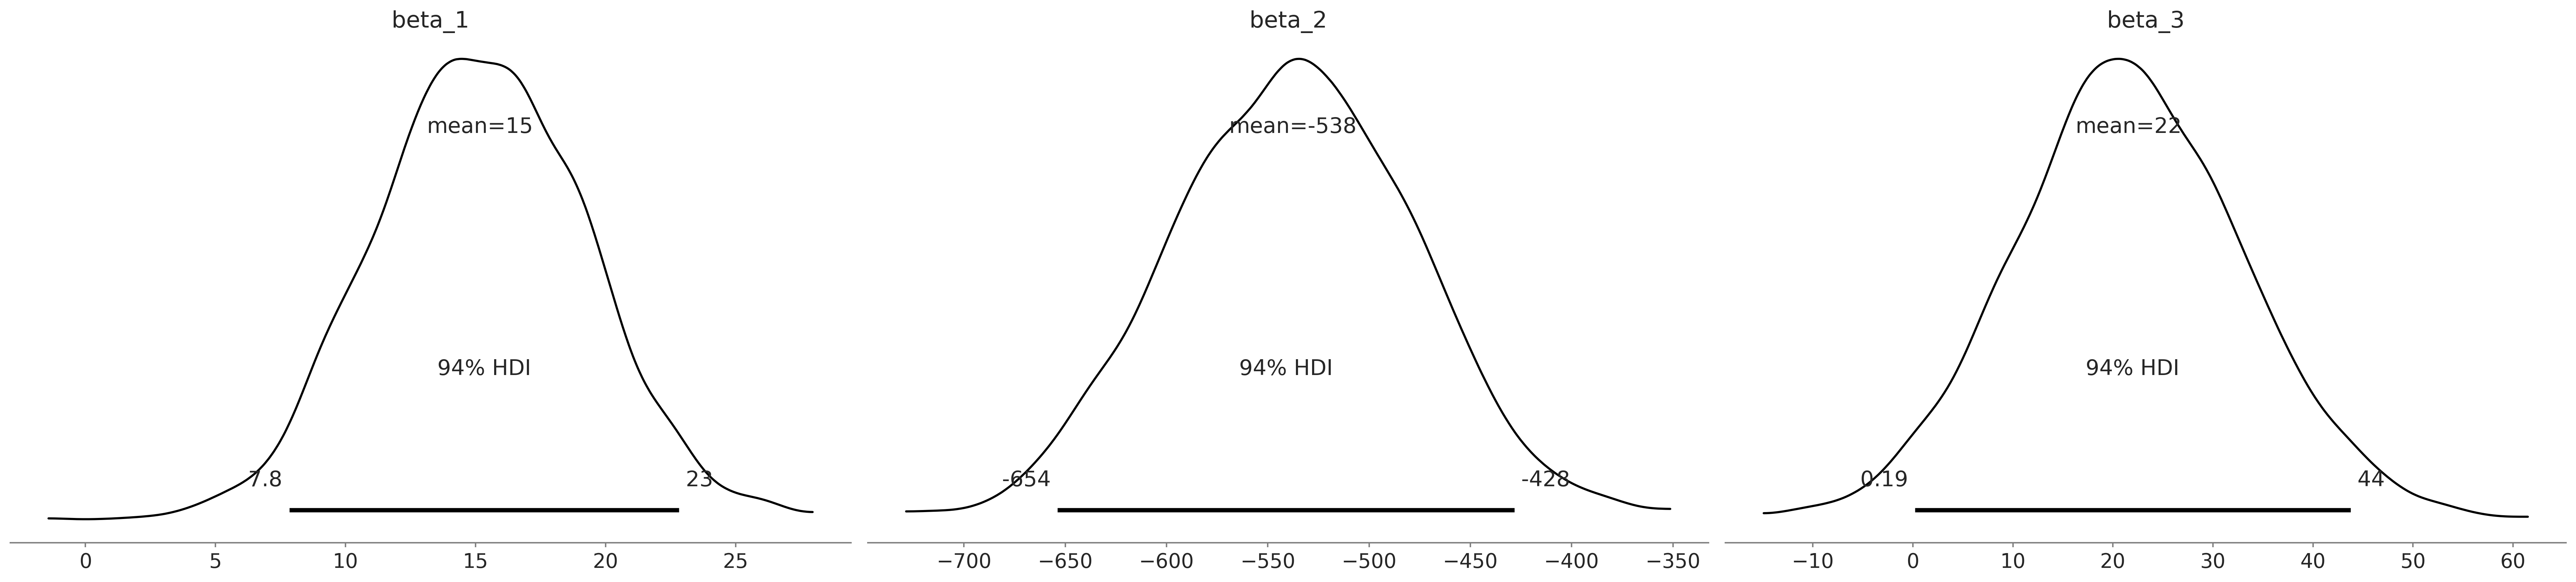

In [35]:
az.plot_posterior(idata_model_penguin_flipper_bill_sex, var_names=["beta_1", "beta_2", "beta_3"]) 

In [36]:
az.summary(idata_model_penguin_flipper_bill_sex, var_names=["beta_1", "beta_2", "beta_3"])

mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta_1   15.171   4.063    7.837   22.818      0.099    0.071    1693.0   
beta_2 -537.611  60.610 -653.784 -428.186      1.313    0.930    2130.0   
beta_3   21.567  11.558    0.193   43.754      0.257    0.182    2022.0   

        ess_tail  r_hat  
beta_1    2082.0    1.0  
beta_2    2413.0    1.0  
beta_3    1959.0    1.0

In [37]:
# Simulate mass of penguins with different fictional flipper lengths
# fixing gender as male and bill length as observed mean of dataset
mean_flipper_length = penguins.loc[adelie_mask, "flipper_length_mm"].mean()
counterfactual_flipper_lengths = np.linspace(mean_flipper_length-20, mean_flipper_length+20, 21)
sex_male_indicator = np.zeros_like(counterfactual_flipper_lengths)
mean_bill_length = np.ones_like(counterfactual_flipper_lengths) * bill_length_obs.mean()

jd_flipper_bill_sex_counterfactual = gen_jd_flipper_bill_sex(
    counterfactual_flipper_lengths, sex_male_indicator, mean_bill_length)

ppc_samples = jd_flipper_bill_sex_counterfactual.sample(value=mcmc_samples)
estimated_mass = ppc_samples[-1].numpy().reshape(-1,21)

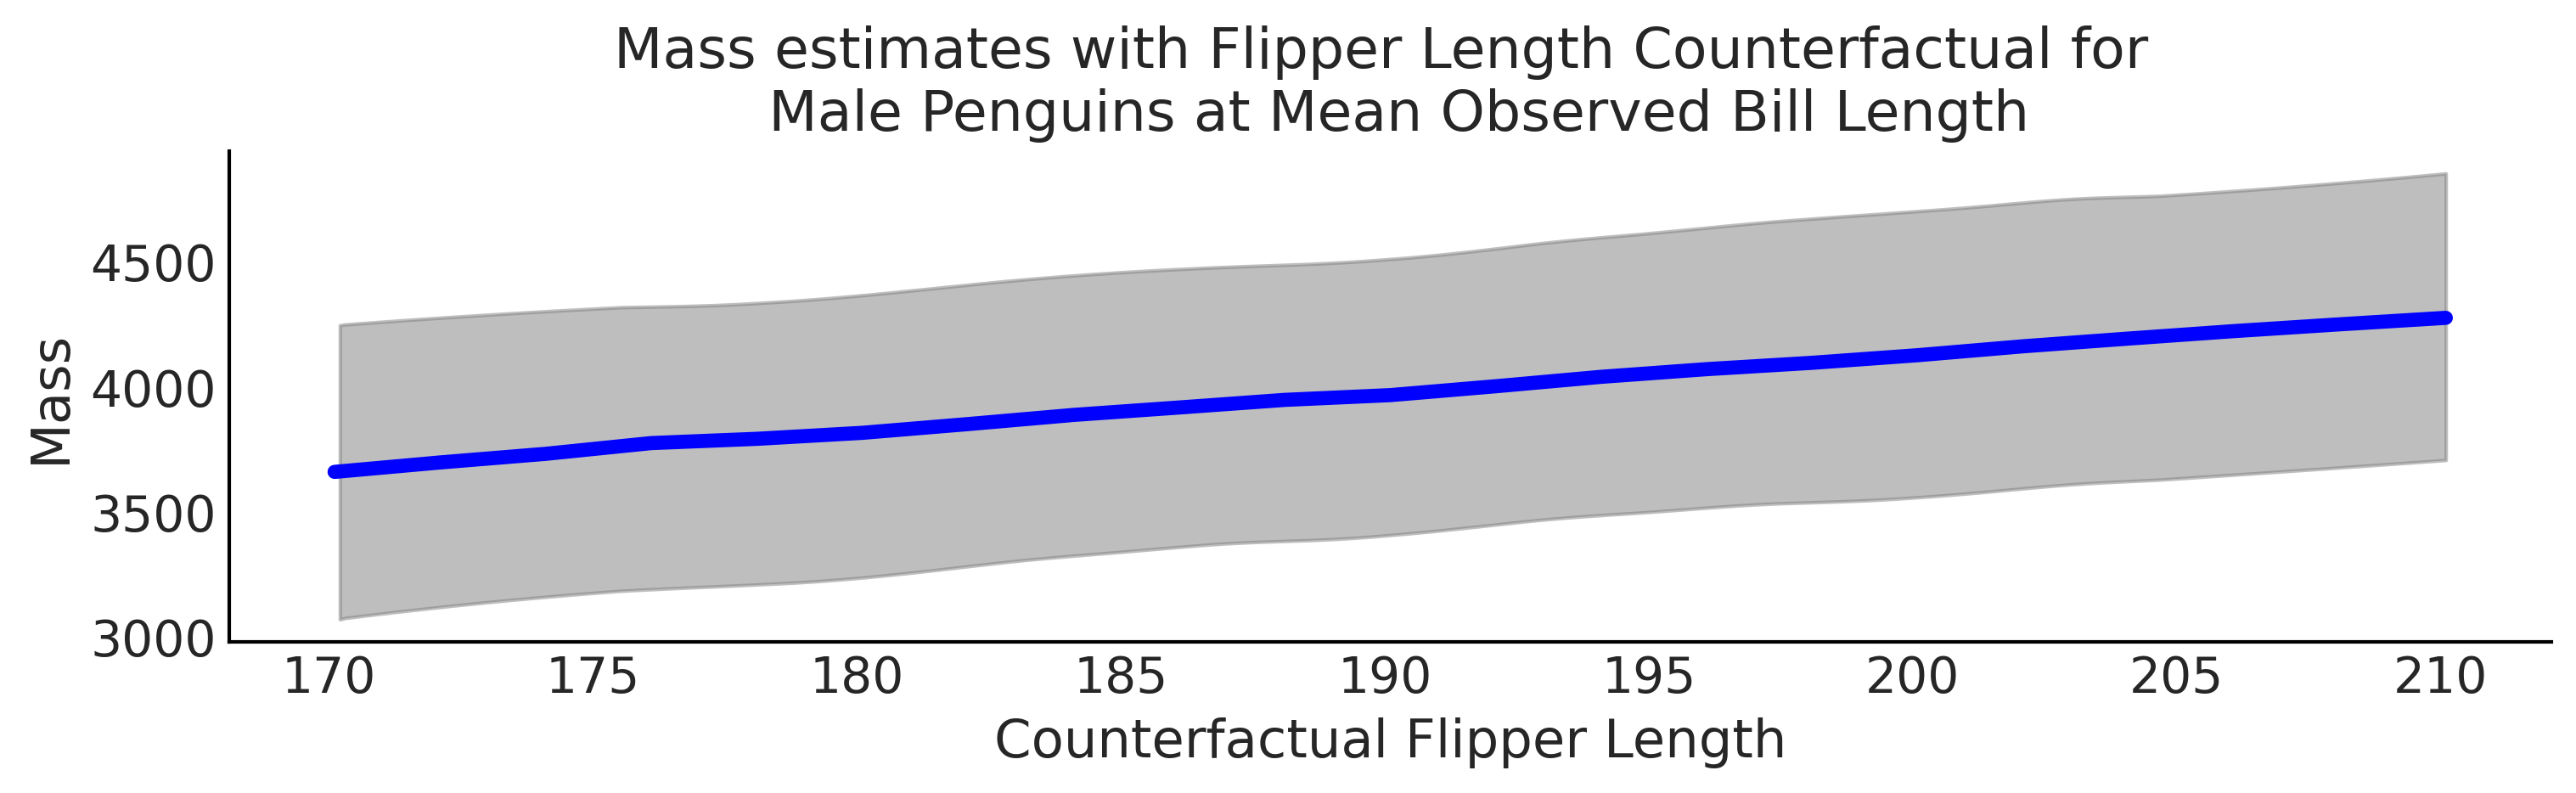

In [38]:
_, ax = plt.subplots(figsize=(10, 3))
az.plot_hdi(counterfactual_flipper_lengths, estimated_mass, color="C2", plot_kwargs={"ls": "--"}, ax=ax)
ax.plot(counterfactual_flipper_lengths, estimated_mass.mean(axis=0), lw=4, c="blue")
ax.set_title("Mass estimates with Flipper Length Counterfactual for \n Male Penguins at Mean Observed Bill Length")
ax.set_xlabel("Counterfactual Flipper Length")
ax.set_ylabel("Mass")
plt.savefig("img/chap03/linear_counter_factual.png")

## Generalized Linear Models

In [39]:
# Classifying Penguins
# Given the mass, sex, and bill length of a penguin can we predict the species?
species_filter = penguins["species"].isin(["Adelie", "Chinstrap"])
bill_length_obs = penguins.loc[species_filter, "bill_length_mm"].values
species = pd.Categorical(penguins.loc[species_filter, "species"])

with pm.Model() as model_logistic_penguins_bill_length:
    β_0 = pm.Normal("β_0", mu=0, sigma=10)
    β_1 = pm.Normal("β_1", mu=0, sigma=10)

    μ = β_0 + pm.math.dot(bill_length_obs, β_1)

    # Application of our sigmoid  link function
    θ = pm.Deterministic("θ", pm.math.sigmoid(μ))

    # Useful for plotting the decision boundary later
    bd = pm.Deterministic("bd", -β_0/β_1)

    # Note the change in likelihood
    yl = pm.Bernoulli("yl", p=θ, observed=species.codes)

    idata_logistic_penguins_bill_length = pm.sample(5000, chains=2, random_seed=0,
                                                    idata_kwargs={"log_likelihood":True})
    idata_logistic_penguins_bill_length.extend(pm.sample_prior_predictive(samples=10000))
    idata_logistic_penguins_bill_length.extend(pm.sample_posterior_predictive(idata_logistic_penguins_bill_length))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [β_0, β_1]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 7 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [yl, β_0, β_1]
Sampling: [yl]


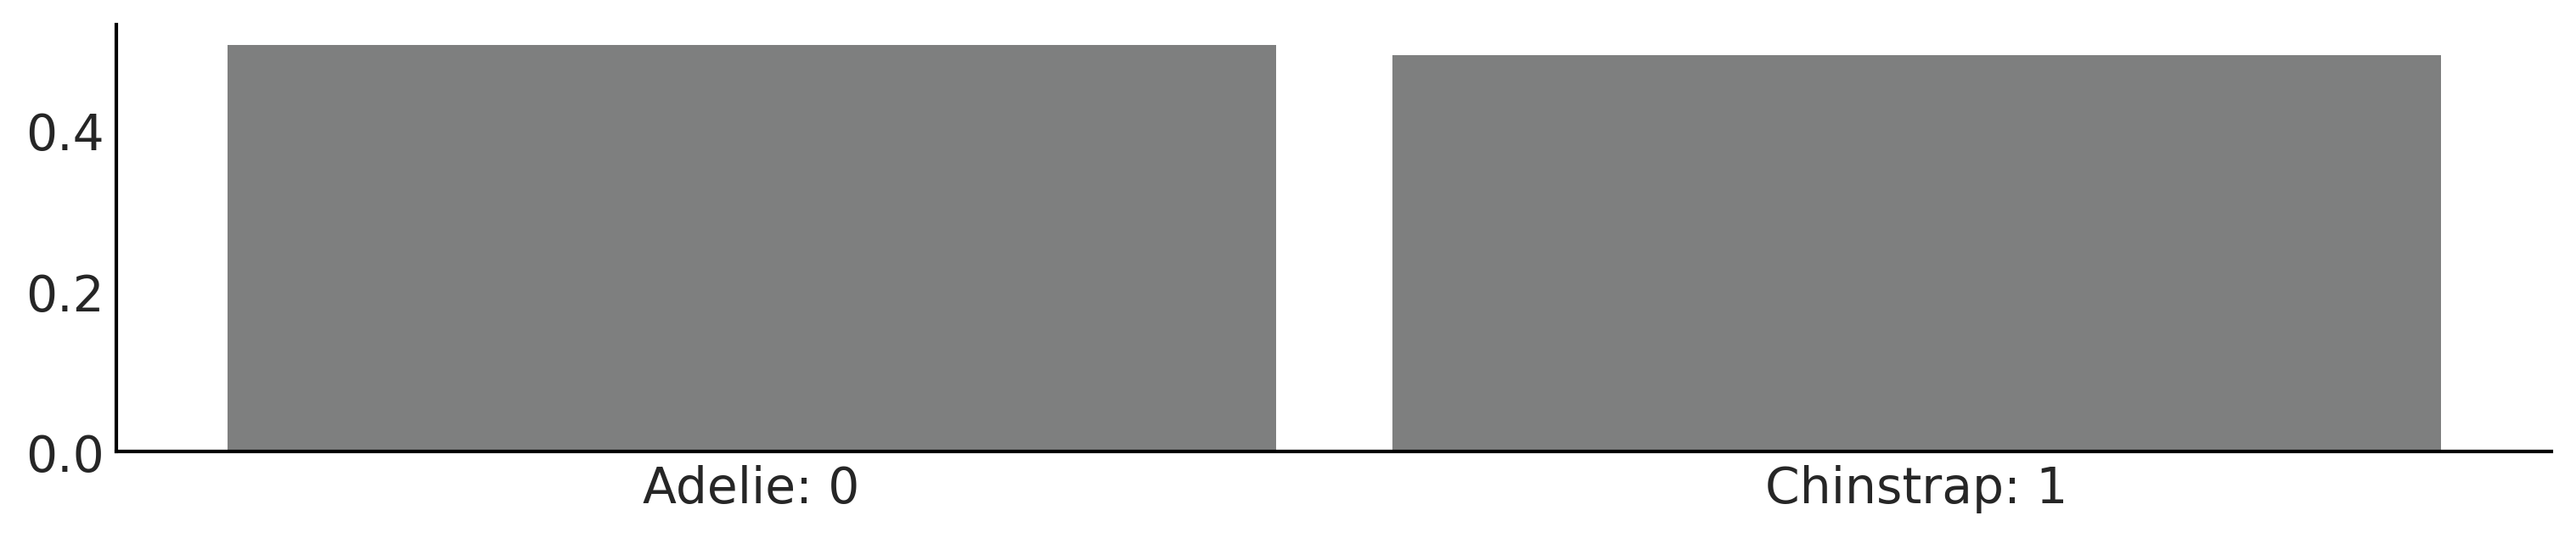

In [40]:
_, ax = plt.subplots(figsize=(10, 2))
az.plot_dist(idata_logistic_penguins_bill_length.prior_predictive["yl"], color="C2", ax=ax)
ax.set_xticklabels(["Adelie: 0", "Chinstrap: 1"] )
plt.savefig("img/chap03/prior_predictive_logistic.png")

In [41]:
az.summary(idata_logistic_penguins_bill_length, var_names=["β_0", "β_1"], kind="stats")

mean     sd  hdi_3%  hdi_97%
β_0 -34.460  4.409 -42.654  -26.075
β_1   0.779  0.101   0.593    0.975

In [42]:
mass_obs = penguins.loc[species_filter, "body_mass_g"].values

with pm.Model() as model_logistic_penguins_mass:
    β_0 = pm.Normal("β_0", mu=0, sigma=10)
    β_1 = pm.Normal("β_1", mu=0, sigma=10)

    μ = β_0 + pm.math.dot(mass_obs, β_1)
    θ = pm.Deterministic("θ", pm.math.sigmoid(μ))
    bd = pm.Deterministic("bd", -β_0/β_1)

    yl = pm.Bernoulli("yl", p=θ, observed=species.codes)


    idata_logistic_penguins_mass = pm.sample(5000, chains=2, 
                                             target_accept=.9, random_seed=0, 
                                             idata_kwargs={"log_likelihood":True})
    idata_logistic_penguins_mass.extend(pm.sample_posterior_predictive(idata_logistic_penguins_mass))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [β_0, β_1]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 6 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [yl]


In [43]:
mass_obs = penguins.loc[species_filter, "body_mass_g"].values

with pm.Model() as model_logistic_penguins_mass:
    β_0 = pm.Normal("β_0", mu=0, sigma=10)
    β_1 = pm.Normal("β_1", mu=0, sigma=10)

    μ = β_0 + pm.math.dot(mass_obs, β_1)
    θ = pm.Deterministic("θ", pm.math.sigmoid(μ))
    bd = pm.Deterministic("bd", -β_0/β_1)

    yl = pm.Bernoulli("yl", p=θ, observed=species.codes)

    idata_logistic_penguins_mass = pm.sample(5000, chains=2, 
                                                target_accept=0.9, random_seed=0,
                                                idata_kwargs={"log_likelihood":True})
    idata_logistic_penguins_mass.extend(pm.sample_posterior_predictive(idata_logistic_penguins_mass))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [β_0, β_1]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 6 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [yl]


array([[<Axes: title={'center': 'β_0'}>,
        <Axes: title={'center': 'β_0'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'β_1'}>,
        <Axes: title={'center': 'β_1'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

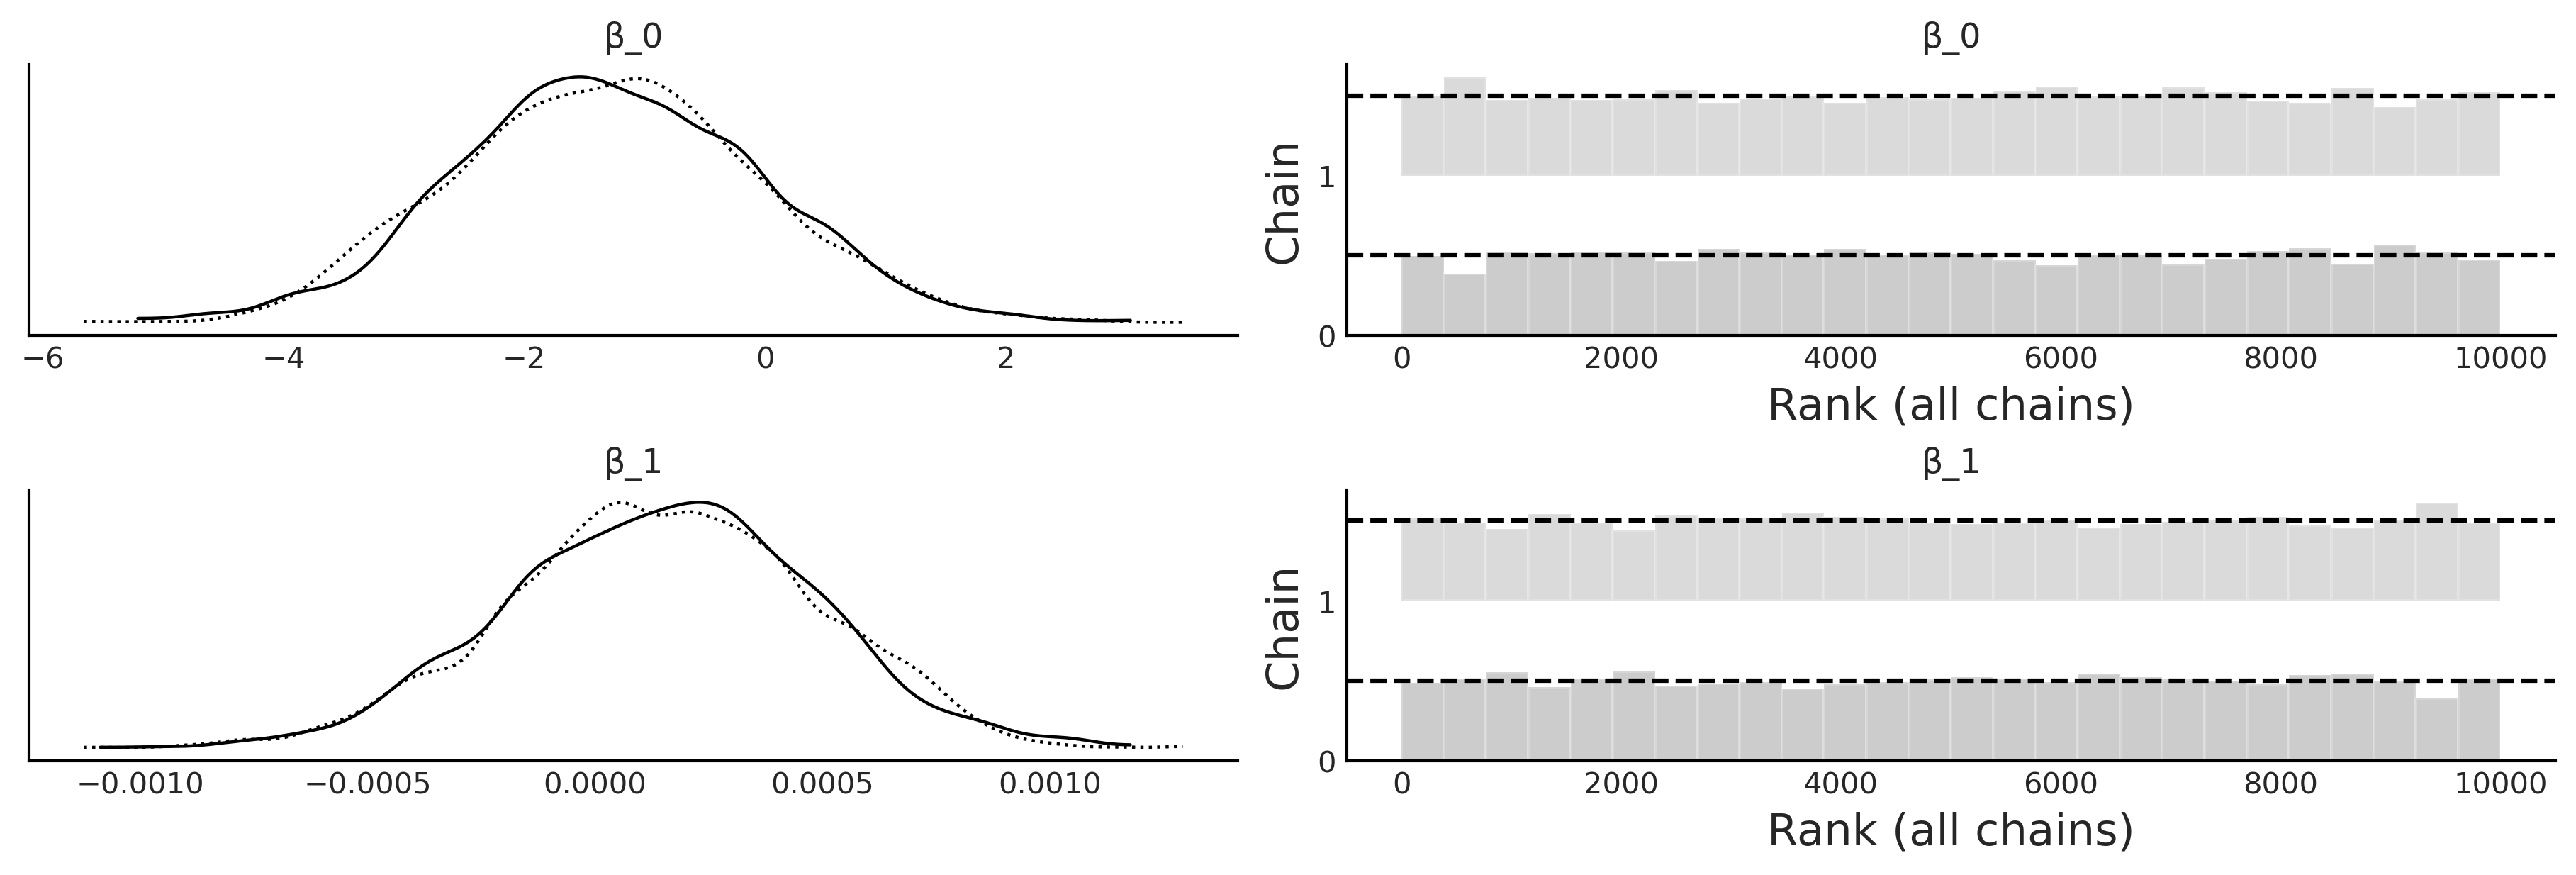

In [44]:
az.plot_trace(idata_logistic_penguins_mass, var_names=["β_0", "β_1"], kind="rank_bars")

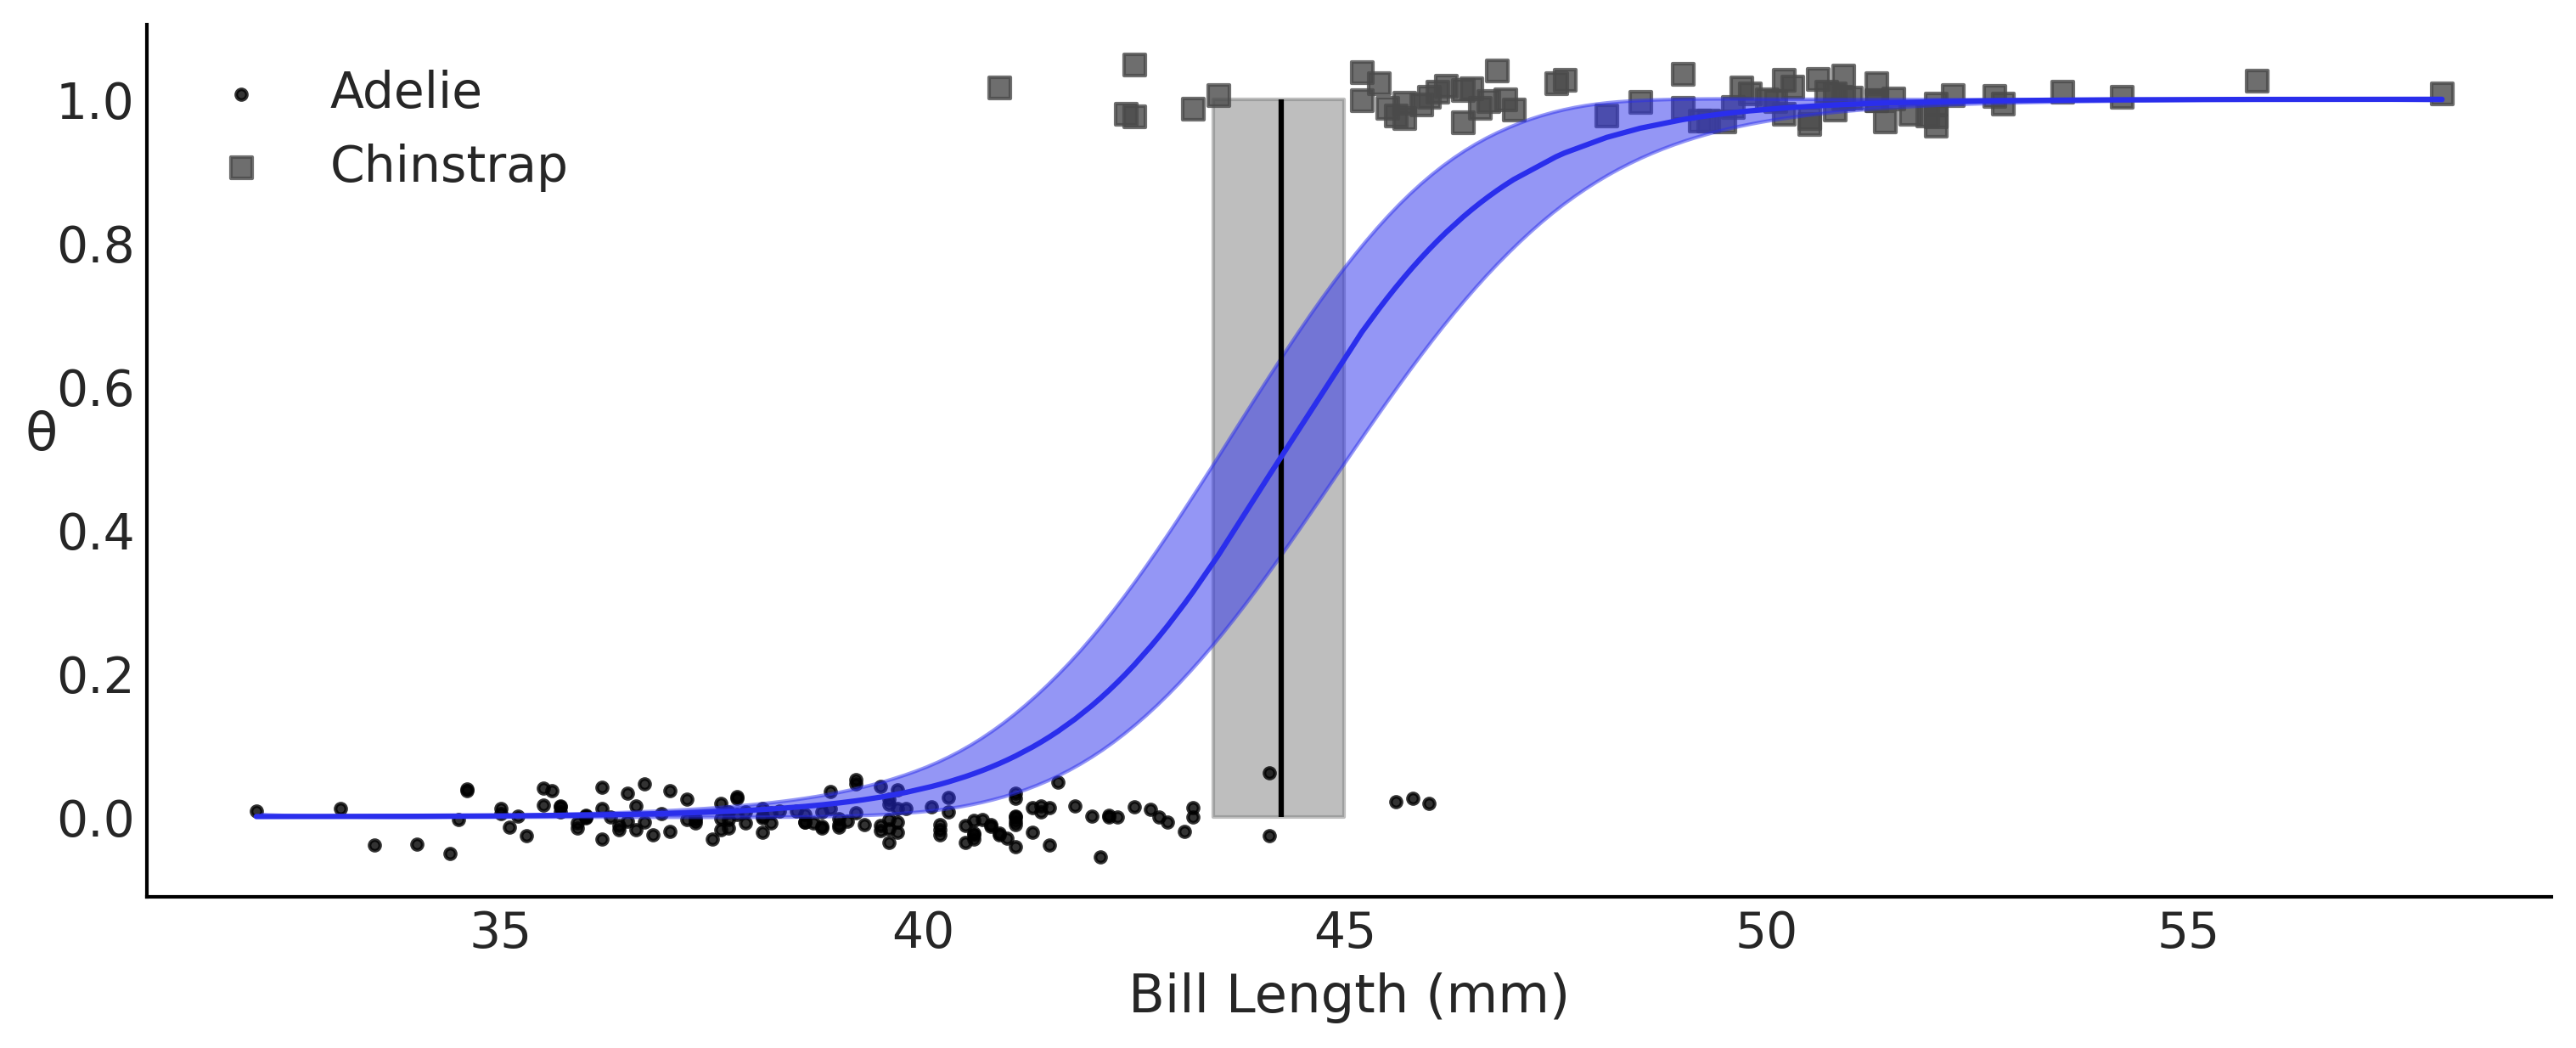

In [45]:
fig, ax = plt.subplots(figsize=(10, 4))

theta = idata_logistic_penguins_bill_length.posterior["θ"].mean(("chain", "draw"))


idx = np.argsort(bill_length_obs)

# Decision Boundary
ax.vlines(idata_logistic_penguins_bill_length.posterior["bd"].values.mean(), 0, 1, color='k')
bd_hpd = az.hdi(idata_logistic_penguins_bill_length.posterior["bd"].values.flatten(), ax=ax)
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='C2', alpha=0.5)


for i, (label, marker) in enumerate(zip(species.categories, (".", "s"))):
    _filter = (species.codes == i)
    x = bill_length_obs[_filter]
    y = np.random.normal(i, 0.02, size=_filter.sum())
    ax.scatter(bill_length_obs[_filter], y, marker=marker, label=label, alpha=.8)

az.plot_hdi(bill_length_obs, idata_logistic_penguins_bill_length.posterior["θ"].values, color='C4', ax=ax, plot_kwargs={"zorder":10})
ax.plot(bill_length_obs[idx], theta[idx], color='C4', zorder=10)

ax.set_xlabel("Bill Length (mm)")
ax.set_ylabel('θ', rotation=0)
plt.legend()
plt.savefig("img/chap03/logistic_bill_length.png")

In [46]:
X = penguins.loc[species_filter, ["bill_length_mm", "body_mass_g"]]

# Add a column of 1s for the intercept
X.insert(0,"Intercept", value=1)
X = X.values

with pm.Model() as model_logistic_penguins_bill_length_mass:
    β = pm.Normal("β", mu=0, sigma=20, shape=3)

    μ = pm.math.dot(X, β)

    θ = pm.Deterministic("θ", pm.math.sigmoid(μ))
    bd = pm.Deterministic("bd", -β[0]/β[2] - β[1]/β[2] * X[:,1])

    yl = pm.Bernoulli("yl", p=θ, observed=species.codes)

    idata_logistic_penguins_bill_length_mass = pm.sample(5000, chains=2,
                                                         random_seed=0, 
                                                         target_accept=.9,
                                                         idata_kwargs={"log_likelihood":True})
    idata_logistic_penguins_bill_length_mass.extend(pm.sample_posterior_predictive(idata_logistic_penguins_bill_length_mass))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [β]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 21 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [yl]


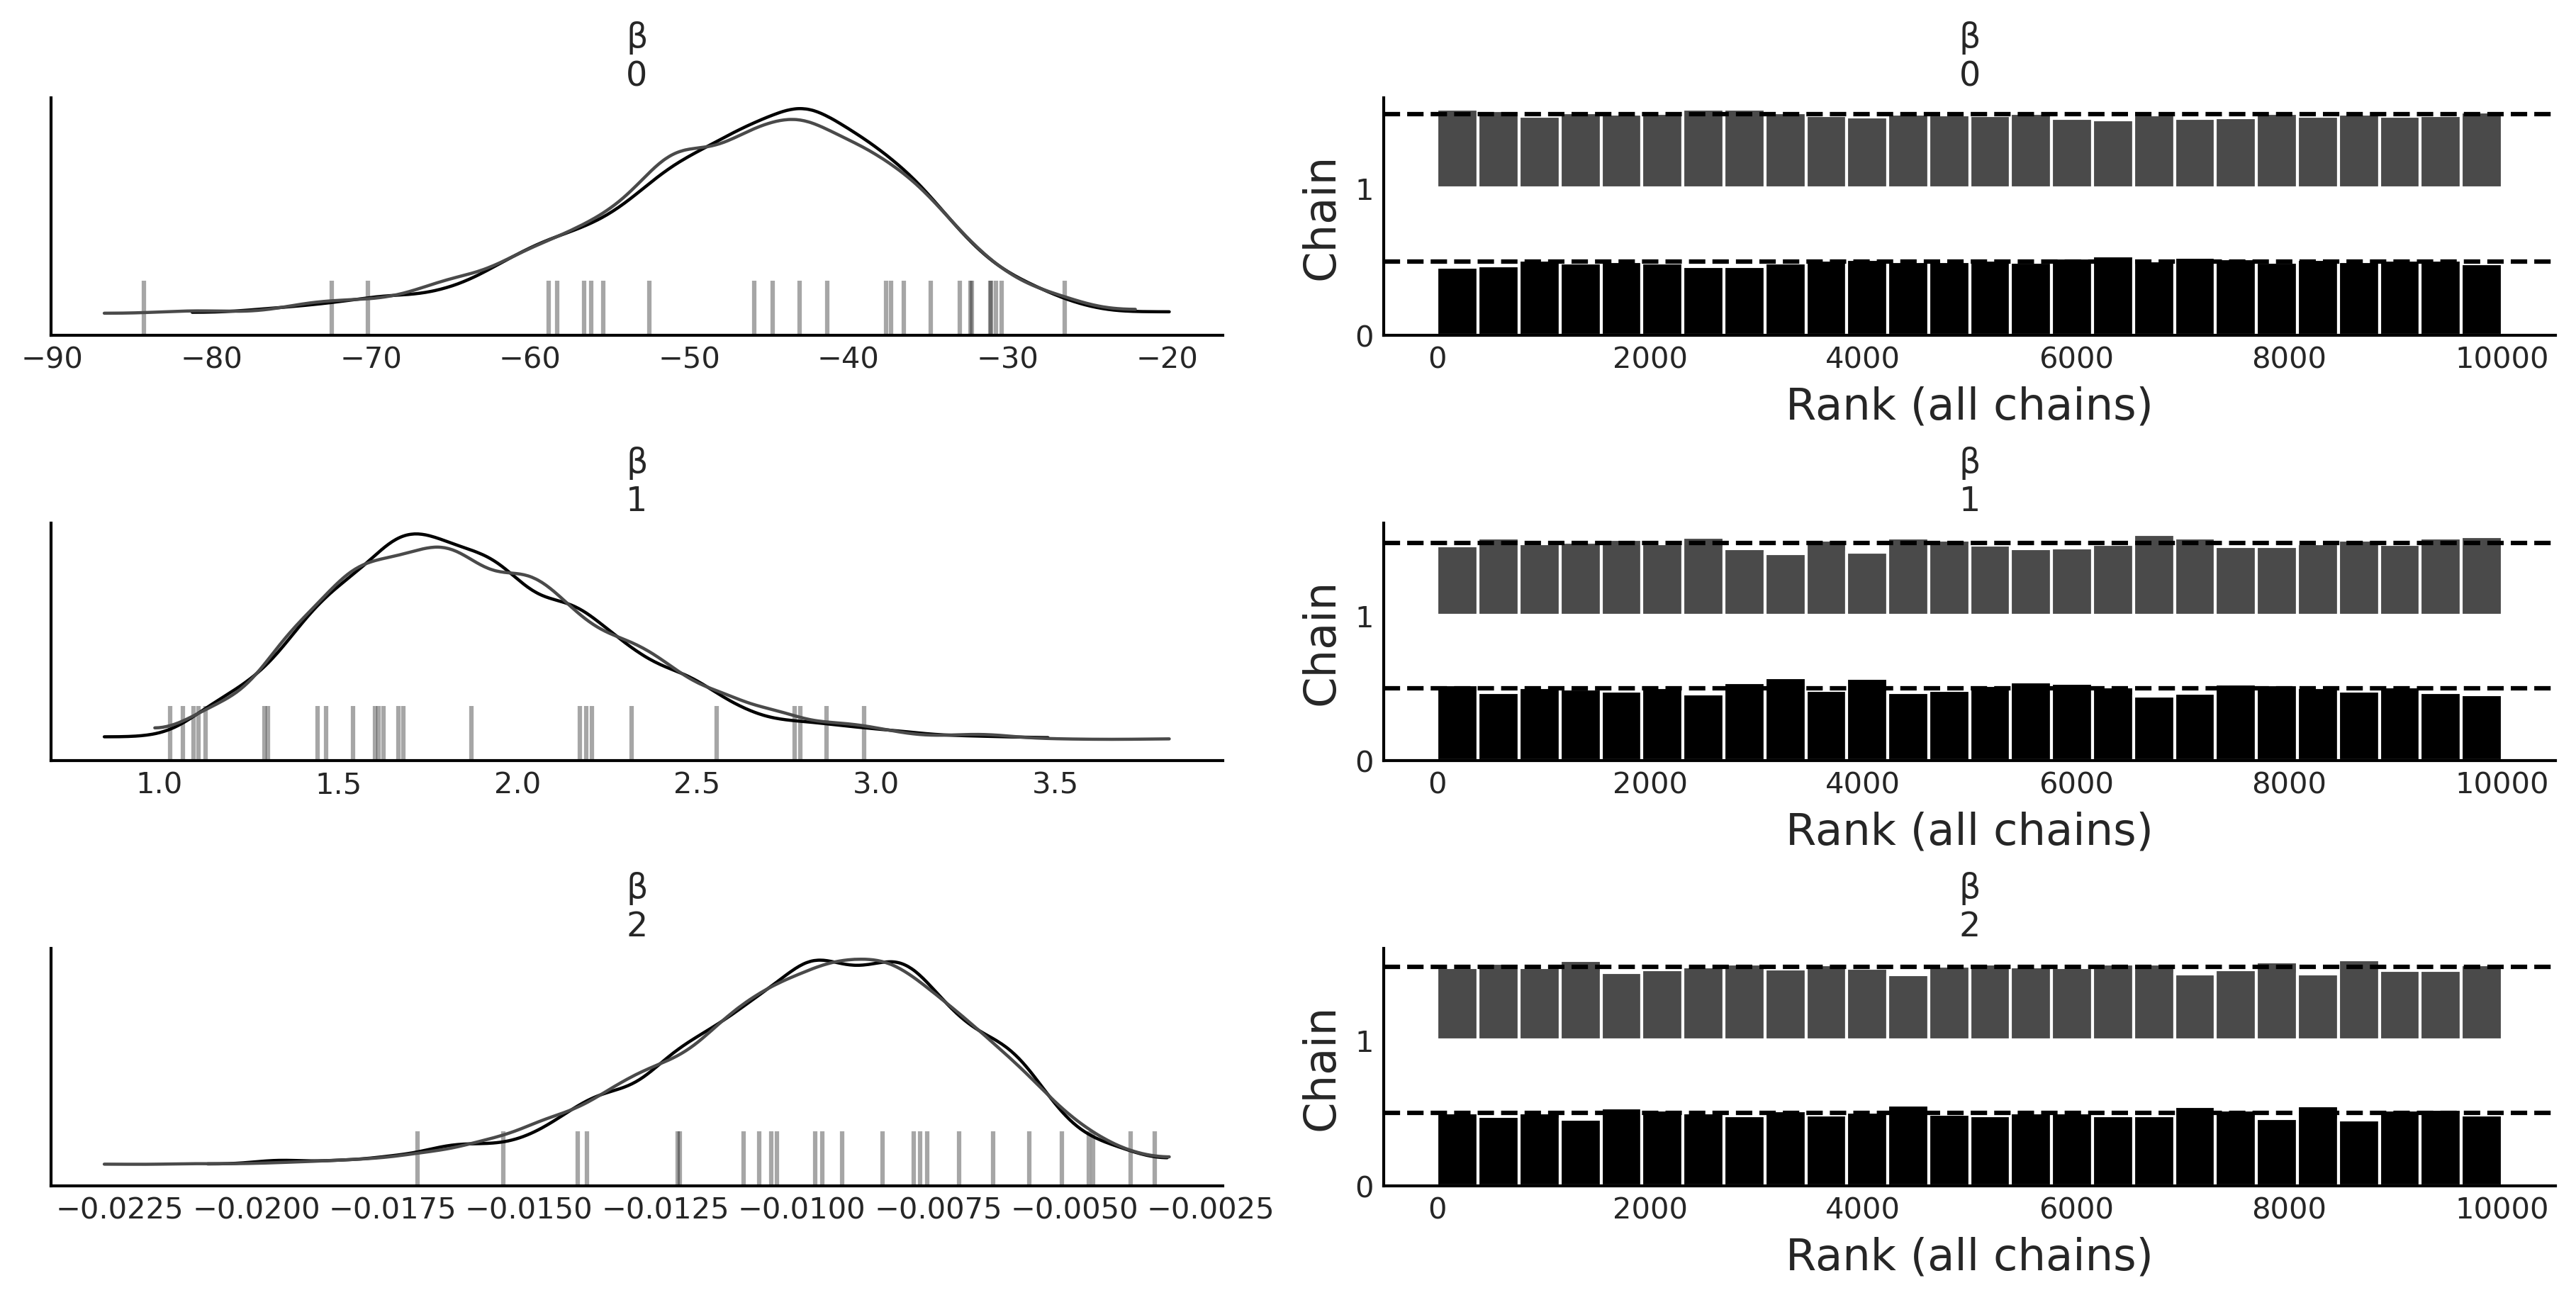

In [47]:
az.plot_trace(idata_logistic_penguins_bill_length_mass, compact=False, var_names=["β"], kind="rank_bars");

In [48]:
models = {"bill": 

SyntaxError: unexpected EOF while parsing (4148087139.py, line 1)

In [ ]:
models = {"bill": idata_logistic_penguins_bill_length,
          "mass": idata_logistic_penguins_mass,
          "mass bill": idata_logistic_penguins_bill_length_mass}

_, axes = plt.subplots(3, 1, figsize=(12, 4), sharey=True)
for (label, model), ax in zip(models.items(), axes):
    az.plot_separation(model, "yl", ax=ax, color="C4")
    ax.set_title(label)

In [ ]:
fig,ax  = plt.subplots()
idx = np.argsort(X[:,1])
bd = idata_logistic_penguins_bill_length_mass.posterior["bd"].mean(("chain", "draw"))[idx]


species_filter = species.codes.astype(bool)

# Linear fit
ax.plot(X[:,1][idx], bd, color='C4');
az.plot_hdi(X[:,1], idata_logistic_penguins_bill_length_mass.posterior["bd"], color='C4', ax=ax)

# Scatter
ax.scatter(X[~species_filter,1], X[~species_filter,2], alpha=.8,  label="Adelie", zorder=10)
ax.scatter(X[species_filter,1], X[species_filter,2], marker="s", label="Chinstrap", zorder=10)


ax.set_ylabel("Mass (grams)")
ax.set_xlabel("Bill Length (mm)")


ax.legend()

In [ ]:
penguins.loc[:,"species"].value_counts()

In [ ]:
counts = penguins["species"].value_counts()
adelie_count = counts["Adelie"],
chinstrap_count = counts["Chinstrap"]
adelie_count / (adelie_count+chinstrap_count)

In [ ]:
   adelie_count / chinstrap_count

In [ ]:
x = 45 
β_0 = inf_data_logistic_penguins_bill_length.posterior["β_0"].mean().values
β_1 = inf_data_logistic_penguins_bill_length.posterior["β_1"].mean().values

bill_length = 45

val_1 = β_0 + β_1 * bill_length
val_2 = β_0 + β_1 * (bill_length+1)

f"Class Probability change from 45mm Bill Length to 46mm: {(special.expit(val_2) - special.expit(val_1))*100:.0f}%"